# Libraries

In [ ]:
#import libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from keras.models import Sequential,Model
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanSquaredError
from tensorflow.keras.callbacks import Callback, TensorBoard, EarlyStopping
from IPython.display import clear_output
import datetime

import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.signal import convolve
import tensorflow as tf
import datetime
from tensorflow.keras.layers import Input,Conv1D, Dense, Flatten, Embedding, Reshape, Softmax,LayerNormalization, MultiHeadAttention, Add, Dropout,Normalization
from tensorflow.keras import Sequential
import numpy as np
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import Callback, TensorBoard
from IPython.display import clear_output
from tensorflow.keras.layers import Dense, LSTM, GRU

# Variables

In [ ]:
Number_channel_uses = 1 # it defines the number of symbols per messages. at a time one symbol can be transmitted

In [ ]:
Eb_No = 10  # This should be a variable so that it can be used in the dictionary
from scipy.stats import truncnorm
from scipy.stats import uniform
channel_parameters = {
    "r"        : 4,                # For upsampling -> number of complex samples per symbol
    "Eb_No"    : Eb_No,            # Energy per bit to noise power spectral density ratio
    "roll_off" : 0.35,             # Roll off factor
    "num_taps" : 31,               # L -> Number of taps (odd) for RRC filter
    "f_s"      : 25e4,             # Sampling frequency
    "T_bound"  : 1/25e4,           # 1/f_s (symbol duration in seconds)
    "time_delay" : np.random.uniform(-1,1),  # Random time delay in the range [-1, 1]
    "CFO"      : 5e3,              # Carrier Frequency Offset in Hz
    "CFO_std"  : 5e3/25e4,         # Normalized Carrier Frequency Offset
    "noise_std": 10**(-1.0 * Eb_No / 10),  # Noise standard deviation, calculated from Eb_No
    "phase_off": uniform.rvs(scale=2*np.pi)  # Random phase offset in the range [0, 2π]
}

# Real to complex conversion and pulse shaping

In [ ]:
# upsampling

# Function to perform upsampling by a factor of r
def upsampling(inp, r):
    com_reshape = tf.reshape(inp, [-1, 1])
    padding = tf.constant([[0, 0], [0, r - 1]])
    upsampled = tf.pad(com_reshape, padding, mode="CONSTANT")
    upsampled = tf.reshape(upsampled, [-1])  # Flatten back to 1D
    return upsampled

# Function to perform upsampling on IQ signals
def upsample_iq(inp, r):
    real = inp[:, 0]  # Real part
    imag = inp[:, 1]  # Imaginary part

    # Upsample both real and imaginary parts
    real_up = upsampling(real, r)
    imag_up = upsampling(imag, r)

    # Combine the upsampled real and imaginary parts
    upsampled = tf.stack([real_up, imag_up], axis=1)
    return upsampled

# Function to do pulse shaping with NRRC code
import numpy as np
import tensorflow as tf
from scipy.signal import lfilter

# Function to create a normalized RRC filter
def rrc_filter(alpha, sps, num_taps, ts = 1):
    """
    Create a root-raised cosine (RRC) filter.

    Args:
        ts: Sampling period (default is 1).
        alpha: Roll-off factor (0 <= alpha <= 1).
        sps: Samples per symbol (upsampling factor).
        num_taps: Number of filter taps (should be odd).

    Returns:
        RRC filter coefficients.
    """
    t = np.linspace(-num_taps//2, num_taps//2 + 1,num_taps) - 2
    rrc = np.zeros_like(t)

    for i in range(len(t)):
        if t[i] == 0.0:
            rrc[i] = (1.0 - alpha + 4 * alpha / np.pi)/ts
        elif np.abs(t[i]) == ts / (4 * alpha):
            rrc[i] = (alpha /( np.sqrt(2)*ts)) * \
                     ((1 + 2/np.pi) * np.sin(np.pi / (4 * alpha)) +
                      (1 - 2/np.pi) * np.cos(np.pi / (4 * alpha)))
        else:
            rrc[i] = (np.sin(np.pi * (t[i]/ts) * (1 - alpha)) +
                      4 * alpha * (t[i]/ts) * np.cos(np.pi * (t[i]/ts) * (1 + alpha))) / \
                     (np.pi * t[i] * (1 - (4 * alpha * (t[i]/ts))**2))

    # Normalize filter coefficients to ensure unit energy
    rrc = rrc / np.sqrt(np.sum(rrc**2))
    rrc = tf.constant(rrc, dtype=tf.float32)
    # plt.stem(t,rrc)  # Plot for visualization
    # plt.title(f"Time_delay = {10}")
    return rrc


# Function to apply upsampling and filtering using conv1d
def upsample_and_filter(signal, r, alpha, num_taps):
    # Upsample the signal
    upsampled_signal = upsample_iq(signal, r)

    # Create the RRC filter
    rrc = rrc_filter(alpha, r, num_taps)

    # Add a batch and channel dimension for conv1d
    upsampled_signal = tf.expand_dims(upsampled_signal, axis=0)  # Shape: (1, length, 2)
    rrc = tf.reshape(rrc, [-1, 1, 1])  # Shape: (filter_length, 1, 1)

    padding_size = num_taps//2
    paddings = tf.constant([[0, 0], [padding_size, padding_size], [0, 0]])
    padded_real = tf.pad(upsampled_signal[:, :, 0:1], paddings, "CONSTANT")
    padded_imag = tf.pad(upsampled_signal[:, :, 1:2], paddings, "CONSTANT")
    upsampled_signal = tf.concat([padded_real, padded_imag], axis=2)
    print('upsampled shape', upsampled_signal.shape)
    # Apply the RRC filter using conv1d
    real_filtered = tf.nn.conv1d(upsampled_signal[:, :, 0:1], rrc, stride=1, padding='SAME')
    imag_filtered = tf.nn.conv1d(upsampled_signal[:, :, 1:2], rrc, stride=1, padding='SAME')

    # Combine filtered real and imaginary parts
    filtered_signal = tf.concat([real_filtered, imag_filtered], axis=2)
    filtered_signal = tf.squeeze(filtered_signal, axis=0)  # Remove the batch dimension

    return filtered_signal

def time_offset(sampling_time = 10 ):
  t_offset = np.random.uniform(-sampling_time//2, sampling_time//2)
  return t_offset

# def signal_sample(received_signal,fs=1,s_rate = 10,num_taps

# def signal_sample(received_signal,fs=1,s_rate = 10,num_taps):
#     sampling_rate = s_rate*fs
#     signal_sample = received_signal[::sampling_rate]

#     x_axis = np.arange(-num_taps//2, num_taps//2 + 1) / s_rate
#     plt.stem(x_axis[:len(signal_sample)], signal_sample)  # Plot for visualization
#     plt.title(f"Time_delay = {10}")
#     return signal_sample


def pulse_shape_decode(received_signal, fs, alpha, num_taps):
    # fs  = sampling frequency
    # get the samples from received signal tapping


    return None



# Example usage:

# Define parameters
r = 4  # Upsampling factor
alpha = 0.35  # Roll-off factor
num_taps = 2  # Number of filter taps (should be odd)

# # Example input: Complex signal with real and imaginary parts
# input_signal = tf.constant([[1.0, -1.0]])

# # Apply upsampling and RRC filtering
# filtered_signal = upsample_and_filter(input_signal, r, alpha, num_taps)

# filtered_signal_real = filtered_signal[:, 0].numpy()
# # sampled_signal = signal_sample(filtered_signal_real,fs=1,s_rate = 10)


# # Generate x-axis data with matching length
# x_axis = np.arange(-num_taps//2, num_taps//2 + 1) / r

# plt.stem(x_axis[:len(filtered_signal_real)], filtered_signal_real)  # Plot for visualization
# plt.title(f"Time_delay = {10}")
# print("Filtered Signal:")
# print(len(filtered_signal))


# Example input: Complex signal with real and imaginary parts
input_signal = tf.constant([[1.0, -1.0]])  # Example input signal with 2 samples

print(f"Input signal length: {len(input_signal)}")

# Apply upsampling and RRC filtering
filtered_signal = upsample_and_filter(input_signal, r, alpha, num_taps)

# Print lengths
upsampled_signal_length = len(upsample_iq(input_signal, r))
expected_output_length = upsampled_signal_length + num_taps - 1
print(f"Upsampled signal length: {upsampled_signal_length}")
print(f"Expected output length: {expected_output_length}")
print(f"Actual filtered signal length: {len(filtered_signal)}")

# Visualize the filtered signal
filtered_signal_real = filtered_signal[:, 0].numpy()

# Generate x-axis data with matching length
x_axis = np.arange(len(filtered_signal_real))

plt.stem(x_axis, filtered_signal_real)  # Plot for visualization
plt.title(f"Filtered Signal with Time_delay = {10}")
plt.show()




In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter

# function to create the complex values
def real_to_complex_tensor(inp_tensor):
  inp_tensor = tf.reshape(inp_tensor, [-1, 2])
  real_part = inp_tensor[:, 0]
  imag_part = inp_tensor[:, 1]
  complex_tensor = tf.complex(real_part, imag_part)
  return complex_tensor

def complex_to_real_tensor(inp_tensor):
   real_part , imag_part = tf.math.real(inp_tensor), tf.math.imag(inp_tensor)
   real_part = tf.reshape(real_part,[-1,1])
   imag_part = tf.reshape(imag_part,[-1,1])
   return tf.reshape(tf.concat([real_part,imag_part],1),[-1])

# RRC Filter Design
class NRRC_filter(tf.keras.layers.Layer):

  def __init__(self,beta,span,sps,input):
    super(NRRC_filter, self).__init__(**kwargs)
    self.beta = beta
    self.span = span
    self.sps = sps
    self.input = input

  def build(self,beta, span, sps):
        """
        Create a Root Raised Cosine (RRC) filter (FIR) impulse response.

        Parameters:
        beta : Roll-off factor (0 <= beta <= 1)
        span : Filter span in symbols
        sps : Samples per symbol

        Returns:
        h_rrc : RRC filter coefficients (impulse response)
        """
        t = np.linspace(-span / 2, span / 2, span * sps + 1)
        h_rrc = np.zeros_like(t)

        for i in range(len(t)):
            if t[i] == 0.0:
                h_rrc[i] = 1.0 - beta + (4 * beta / np.pi)
            elif abs(t[i]) == 1 / (4 * beta):
                h_rrc[i] = (beta / np.sqrt(2)) * (((1 + 2 / np.pi) * np.sin(np.pi / (4 * beta))) +
                                                  ((1 - 2 / np.pi) * np.cos(np.pi / (4 * beta))))
            else:
                h_rrc[i] = (np.sin(np.pi * t[i] * (1 - beta)) +
                            4 * beta * t[i] * np.cos(np.pi * t[i] * (1 + beta))) / \
                          (np.pi * t[i] * (1 - (4 * beta * t[i]) ** 2))

        # Normalize filter energy to 1
        h_rrc = h_rrc / np.sqrt(np.sum(h_rrc ** 2))
        return h_rrc

  def call(self, input):

      """
      Apply pulse shaping to a bitstream using a given filter.

      Parameters:
      bitstream : Input bitstream (BPSK symbols)
      h_rrc : RRC filter coefficients
      sps : Samples per symbol

      Returns:
      shaped_signal : Pulse-shaped signal
      """
      # Upsample the bitstream (insert zeros between symbols)
      upsampled = np.zeros(len(input) * sps)
      upsampled[::sps] = input

      # Convolve with the RRC filter
      shaped_signal = lfilter(h_rrc, 1.0, input)
      return shaped_signal

  def get_config(self):
      config = super(NRRC_filter, self).get_config()
      config.update({'beta': self.beta, 'span': self.span, 'sps': self.sps})
      return config
# Pulse Shaping
def pulse_shaping(bitstream, h_rrc, sps):
    """
    Apply pulse shaping to a bitstream using a given filter.

    Parameters:
    bitstream : Input bitstream (BPSK symbols)
    h_rrc : RRC filter coefficients
    sps : Samples per symbol

    Returns:
    shaped_signal : Pulse-shaped signal
    """
    # Upsample the bitstream (insert zeros between symbols)
    upsampled = np.zeros(len(bitstream) * sps)
    upsampled[::sps] = bitstream

    # Convolve with the RRC filter
    shaped_signal = lfilter(h_rrc, 1.0, bitstream)
    return shaped_signal

# Parameters
beta = 0.35  # Roll-off factor
span = 31    # Filter span (in symbols)
sps = 4      # Samples per symbol
num_bits = 100  # Number of bits

# Generate a random bitstream (BPSK symbols: -1, 1)
bitstream = 2 * np.random.randint(0, 2, num_bits) - 1

# Create the RRC filter
h_rrc = rrc_filter(beta, span, sps)

# Perform pulse shaping
shaped_signal = pulse_shaping(bitstream, h_rrc, sps)

# Normalize the shaped signal
shaped_signal /= np.max(np.abs(shaped_signal))

# Plot the original bitstream and the pulse-shaped signal
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
#plt.stem(np.arange(len(bitstream)), bitstream, 'b', markerfmt='bo', basefmt=" ", use_line_collection=True) to resolve error
plt.stem(np.arange(len(bitstream)), bitstream, 'b', markerfmt='bo', basefmt=" ")
plt.title('Original Bitstream')
plt.xlabel('Bit Index')
plt.ylabel('Amplitude')

plt.subplot(2, 1, 2)
plt.plot(shaped_signal, 'r')
plt.title('Pulse-Shaped Signal (Normalized RRC)')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()


# implementation of AE with noise channel working.

In [ ]:
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
# import numpy as np
# import math
# import matplotlib.pyplot as plt

# Dataset Parameters
N = 4  # Number of channel uses
M = 16  # Number of total messages that can be transmitted
K = int(math.ceil(np.log2(M)))  # Block size
l = 6
Eb_No = 10
batch_size = (2*l+1)*320

# Create Dataset in one-hot vector
alphabet_size = pow(2, K)
alphabet = np.eye(alphabet_size, dtype='float32')

train_dataset = np.tile(alphabet, (batch_size, 1))
test_dataset = np.tile(alphabet, (batch_size * 10, 1))

# Custom Callback for Real-time Plotting
class PlottingCallback(Callback):
    def __init__(self):
        super(PlottingCallback, self).__init__()
        self.history = {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}

    def on_epoch_end(self, epoch, logs=None):
        # Update history
        self.history['accuracy'].append(logs.get('accuracy'))
        self.history['val_accuracy'].append(logs.get('val_accuracy'))
        self.history['loss'].append(logs.get('loss'))
        self.history['val_loss'].append(logs.get('val_loss'))

        # Clear previous output
        clear_output(wait=True)

        # Plot training and validation accuracy
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(self.history['accuracy'], label='Training Accuracy')
        plt.plot(self.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Accuracy over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        # Plot training and validation loss
        plt.subplot(1, 2, 2)
        plt.plot(self.history['loss'], label='Training Loss')
        plt.plot(self.history['val_loss'], label='Validation Loss')
        plt.title('Loss over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.show()

# Normalization Layer
class Normalization(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(Normalization, self).__init__(**kwargs)

    def call(self, input):
        shape = tf.shape(input)
        out = tf.nn.l2_normalize(tf.reshape(input, (-1, 2)), axis=-1, epsilon=1e-5)
        # out = tf.nn.l2_normalize(tf.reshape(input, (-1, 2*N)), axis=-1, epsilon=1e-5)                                # to normalize the power of symbol
        # out = tf.nn.l2_normalize(tf.reshape(input, (-1, shape[-1])), axis=-1, epsilon=1e-5)  # to normalize the power of all the signal
        out = tf.reshape(out, (-1,2*N))
        print(" Normalize each input power to 1,shape ",out.shape)
        return out

    def get_config(self):
        return super(Normalization, self).get_config()

# Custom Noise Layer
class CustomNoise(tf.keras.layers.Layer):
    def __init__(self, mean=0.0, stddev=10**(-1.0*Eb_No), **kwargs):
        super(CustomNoise, self).__init__(**kwargs)
        self.mean = mean
        self.stddev = stddev

    def call(self, inputs):
        noise = tf.random.normal(shape=tf.shape(inputs), mean=self.mean, stddev=self.stddev)
        return inputs + noise

import tensorflow as tf
from tensorflow.keras.layers import Layer

# class RealToComplexPair(tf.keras.layers.Layer):
#     def __init__(self, **kwargs):
#         super(RealToComplexPair, self).__init__(**kwargs)

#     def call(self, inputs):
#         # Get the inner dimension size
#         inner_dimension = inputs.shape[-1] // 2  # Assuming the last dimension is even

#         # Create indices for real and imaginary parts
#         real_indices = tf.range(0, 2 * inner_dimension, 2)
#         imag_indices = tf.range(1, 2 * inner_dimension, 2)

#         # Extract real and imaginary parts using the indices
#         real_part = tf.gather(inputs, real_indices, axis=-1)
#         imag_part = tf.gather(inputs, imag_indices, axis=-1)

#         # Combine the real and imaginary parts into a complex tensor
#         complex_tensor = tf.complex(real_part, imag_part)
#         return complex_tensor

#     def compute_output_shape(self, input_shape):
#         # Output shape will have half the last dimension (as complex numbers)
#         return input_shape[:-1] + (input_shape[-1] // 2,)

#     def get_config(self):
#         config = super(RealToComplexPair, self).get_config()
#         return config



class AE:
    def __init__(self, train_data=train_dataset, test_data=test_dataset, input_dim=K, enc_dim=N, act_fun='tanh'):
        self.train_data = train_data
        self.test_data = test_data
        self.input_dim = input_dim
        self.enc_dim = enc_dim
        self.act_fun = act_fun

    def AE_implement(self):
        autoencoder = Sequential([
            Dense(2**(self.input_dim), activation=self.act_fun, name="Input"),
            Dense(2**(self.input_dim), activation=self.act_fun, name="encoder"),
            Dense(2**(self.input_dim), activation=self.act_fun, name="middle1"),
            Dense(self.enc_dim * 2, activation=self.act_fun, name='middle2'),

            # Convert to complex tensor
            # RealToComplexPair(name = 'real2complex'),

            # Normalization Layer
            Normalization(name = 'normalization'),

            # Channel Layer
            StochasticChannelv3_cts_tr(name = 'stc'),
            # NormalizedRRCFilterLayer( ),
            CustomNoise(name = 'noise'),
            SD(name = 'sd'),
            # CustomNoise(

            # Decoder layers
            Dense(self.enc_dim * 4, activation=self.act_fun, name="decoder1"),
            Dense(2**(self.input_dim), activation=self.act_fun, name='decoder2'),
            Dense(2**(self.input_dim), activation='softmax', name='Output')
        ])

        autoencoder.compile(optimizer=Adam(learning_rate=1e-2), loss='categorical_crossentropy',metrics=['accuracy'])
        return autoencoder

    def train(self, epochs=20, batch_size=64):
        autoencoder = self.AE_implement()
        # autoencoder.fit(self.train_data, self.train_data,
        #                 epochs=epochs, batch_size=batch_size,
        #                 validation_data=(self.test_data, self.test_data))
        # # return autoencoder

        # TensorBoard setup
        log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
        print(self.test_data.shape)

        history = autoencoder.fit(self.train_data, self.train_data,
                                  epochs=epochs, batch_size=(2*l+1)*16,
                                  validation_data=(self.test_data, self.test_data),
                                  callbacks=[PlottingCallback(), tensorboard_callback])
        return autoencoder, history

# Instantiate the AE class and train the model
ae = AE(train_data=train_dataset[:], test_data=test_dataset[:16*13], input_dim=K, enc_dim=N, act_fun='relu')
autoencoder_model = ae.train(epochs=10, batch_size=(2*l+1))
# print("This is the sample input dimension ",len(train_dataset[0]))
# Evaluate the model on the test data
# print(train_dataset.shape)
# print(test_dataset)



In [ ]:
%reload_ext tensorboard
%load_ext tensorboard
%tensorboard --logdir logs/fit

In [ ]:
enc = tf.constant([[1,1,1,1,0,0,1,0,1,0,1,1,0,1,0,1],
                    [0,1,0,1,0,0,0,1,0,1,1,1,0,1,1,0]],
                   dtype=tf.float32) # enc has been redefined with the correct shape
print(enc.shape)
# Instantiate the layer
output = autoencoder_model[0](test_dataset[:12*13])

# Apply the layer to the input
# output = channel_layer(enc)

# Print the shapes and output
print(output.shape)

print(output)
# accuracy = autoencoder_model[0].evaluate(enc,enc, batch_size = 2)
# print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")


## plot the outputs

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have your input and output from the autoencoder
# Example:
# input_data = your_input_data   # Shape (156, 16)
# output_data = autoencoder.predict(your_input_data)  # Shape (156, 16)

def plot_autoencoder_performance(input_data, output_data, num_samples=5):
    # Ensure the number of samples to plot does not exceed the number of available samples
    num_samples = min(num_samples, input_data.shape[0])

    # Create subplots
    fig, axs = plt.subplots(num_samples, 2, figsize=(10, num_samples * 3))
    fig.suptitle('Autoencoder Input vs Output', fontsize=16)

    for i in range(num_samples):
        # Plot input data (original data)
        axs[i, 0].plot(input_data[i], color='blue')
        axs[i, 0].set_title(f"Input {i+1}")

        # Plot output data (reconstructed data)
        axs[i, 1].plot(output_data[i], color='red')
        axs[i, 1].set_title(f"Output {i+1}")

        # Adding labels
        axs[i, 0].set_ylabel('Amplitude')
        axs[i, 1].set_ylabel('Amplitude')

    # Adding x-axis labels
    axs[-1, 0].set_xlabel('Feature Index')
    axs[-1, 1].set_xlabel('Feature Index')

    plt.tight_layout()
    plt.subplots_adjust(top=0.93)  # Adjust for title
    plt.show()

# Call the plotting function with input and output data
plot_autoencoder_performance(test_dataset[:12*13], output, num_samples=5)  # Adjust num_samples as needed


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have your input and output from the autoencoder
# Example:
# input_data = your_input_data   # Shape (156, 16)
# output_data = autoencoder.predict(your_input_data)  # Shape (156, 16)

def plot_constellation(input_data, output_data, num_samples=5):
    # Ensure the number of samples to plot does not exceed the number of available samples
    num_samples = min(num_samples, input_data.shape[0])

    # Create subplots for constellation
    fig, axs = plt.subplots(num_samples, 2, figsize=(10, num_samples * 5))
    fig.suptitle('Autoencoder Input vs Output Constellation', fontsize=16)

    for i in range(num_samples):
        # Extract real and imaginary parts for input and output
        input_real = input_data[i, ::2]   # Real parts from even indices
        input_imag = input_data[i, 1::2]  # Imaginary parts from odd indices
        output_real = output_data[i, ::2]  # Real parts from even indices
        output_imag = output_data[i, 1::2]  # Imaginary parts from odd indices

        # Plot input constellation
        axs[i, 0].scatter(input_real, input_imag, color='blue', s=50, label='Input')
        axs[i, 0].set_title(f"Input Constellation {i+1}")
        axs[i, 0].set_xlabel('Real')
        axs[i, 0].set_ylabel('Imaginary')
        axs[i, 0].grid(True)

        # Plot output constellation
        axs[i, 1].scatter(output_real, output_imag, color='red', s=50, label='Output')
        axs[i, 1].set_title(f"Output Constellation {i+1}")
        axs[i, 1].set_xlabel('Real')
        axs[i, 1].set_ylabel('Imaginary')
        axs[i, 1].grid(True)

    plt.tight_layout()
    plt.subplots_adjust(top=0.93)  # Adjust for title
    plt.show()

# Call the plotting function with input and output data
plot_constellation(test_dataset[:12*13], output, num_samples=5)  # Adjust num_samples as needed


In [ ]:
autoencoder_model[0].summary()

# Stochastic Channel layer

In [ ]:
# Custom Noise Layer
class CustomNoise(tf.keras.layers.Layer):
    def __init__(self, mean=0.0, stddev=10**(-1.0*Eb_No), **kwargs):
        super(CustomNoise, self).__init__(**kwargs)
        self.mean = mean
        self.stddev = stddev

    def call(self, inputs):
        noise = tf.random.normal(shape=tf.shape(inputs), mean=self.mean, stddev=self.stddev)
        return inputs + noise

class StochasticChannel(tf.keras.layers.Layer):
    def __init__(self, roll_off=0.35, num_taps=101, time_delay=0, rate=1, **kwargs):
        super(StochasticChannel, self).__init__(**kwargs)
        self.num_taps = num_taps
        self.time_delay = time_delay
        self.rate = rate
        self.roll_off = roll_off
        # self.Noise_layer  = CustomNoise(mean=0.0,stddev=channel_parameters['noise_std'])

    def upsampling(self, input):
        input = tf.reshape(input, [-1, 1])
        padding = tf.constant([[0, 0], [0, self.rate - 1]])
        upsampled = tf.pad(input, padding, "CONSTANT")
        print("shape after upsamping:", input.shape)
        return tf.reshape(upsampled, [-1])

    def upsample_iq(self, input):
        inner_dimension = ( input.shape[1])
        N = inner_dimension//2
        Real, Imag = [],[]
        for i in range(N):
          real_t,imag_t = input[:,2*i],input[:,2*i+1]
          Real.extend(real_t)
          Imag.extend(imag_t)
        input = tf.stack([Real, Imag], axis=1)


        # Create indices for real and imaginary parts
        real_indices = tf.range(0, inner_dimension-1, 2)
        imag_indices = tf.range(1, inner_dimension, 2)

        # # Extract real and imaginary parts using the indices
        # real_part = tf.gather(input[:], real_indices, axis=-1)
        # imag_part = tf.gather(input[:], imag_indices, axis=-1)

        # Convert indices to numpy for slicing
        real_indices = real_indices.numpy()
        imag_indices = imag_indices.numpy()

        real = input[:, real_indices]
        imag = input[:, imag_indices]
        print("input dimension:", input.shape)
        real_up = self.upsampling(real)
        imag_up = self.upsampling(imag)
        return tf.stack([real_up, imag_up], axis=1)

    def rrc_filter(self):
        """
        Create a root-raised cosine (RRC) filter.

        Returns:
            RRC filter coefficients.
        """
        t = np.linspace(-self.num_taps // 2, self.num_taps // 2, self.num_taps)
        rrc = np.zeros_like(t)

        for i in range(len(t)):
            if t[i] == 0.0:
                rrc[i] = (1.0 - self.roll_off + 4 * self.roll_off / np.pi)
            elif np.abs(t[i]) == 1 / (4 * self.roll_off):
                rrc[i] = (self.roll_off / (np.sqrt(2))) * \
                         ((1 + 2 / np.pi) * np.sin(np.pi / (4 * self.roll_off)) +
                          (1 - 2 / np.pi) * np.cos(np.pi / (4 * self.roll_off)))
            else:
                rrc[i] = (np.sin(np.pi * (t[i]) * (1 - self.roll_off)) +
                          4 * self.roll_off * (t[i]) * np.cos(np.pi * (t[i]) * (1 + self.roll_off))) / \
                         (np.pi * t[i] * (1 - (4 * self.roll_off * (t[i])) ** 2))

        # Normalize filter coefficients to ensure unit energy
        rrc = rrc / np.sqrt(np.sum(rrc ** 2))
        rrc = tf.constant(rrc, dtype=tf.float32)
        return rrc

    def upsample_and_filter(self, input):
        # Reshape the input dimension
        # input = tf.reshape(input, [-1, 2])

        # Upsample the signal
        upsampled_signal = self.upsample_iq(input)

        # Create the RRC filter
        rrc = self.rrc_filter()

        # Add a batch and channel dimension for conv1d
        upsampled_signal = tf.expand_dims(upsampled_signal, axis=0)  # Shape: (1, length, 2)
        rrc = tf.reshape(rrc, [-1, 1, 1])  # Shape: (filter_length, 1, 1)

        padding_size = self.num_taps // 2
        paddings = tf.constant([[0, 0], [padding_size, padding_size], [0, 0]])
        padded_real = tf.pad(upsampled_signal[:, :, 0:1], paddings, "CONSTANT")
        padded_imag = tf.pad(upsampled_signal[:, :, 1:2], paddings, "CONSTANT")
        padded_signal = tf.concat([padded_real, padded_imag], axis=2)

        # Apply the RRC filter using conv1d
        real_filtered = tf.nn.conv1d(padded_signal[:, :, 0:1], rrc, stride=1, padding='VALID')
        imag_filtered = tf.nn.conv1d(padded_signal[:, :, 1:2], rrc, stride=1, padding='VALID')

        # Combine filtered real and imaginary parts
        filtered_signal = tf.concat([real_filtered, imag_filtered], axis=2)
        print("input shape; ",input.shape)
        print("shape after filtering:", filtered_signal.shape)
        filtered_signal = tf.squeeze(filtered_signal, axis=0)  # Remove the batch dimension
        print("shape after squeeze:", filtered_signal[0])

        return filtered_signal

    def call(self, inputs):
        # Apply upsampling and RRC filtering
        filtered_signal = self.upsample_and_filter(inputs)

        # Log the filtered signal for TensorBoard visualization
        with tf.summary.create_file_writer('logs/stochastic_channel').as_default():
            tf.summary.histogram("Filtered Signal", filtered_signal, step=0)

        return filtered_signal

y = StochasticChannel()(train_dataset)
print(train_dataset.shape)
print("-------------------------------------------------------------")
print(y.shape)

# partially working stochastic channel


In [ ]:
# input_layer = autoencoder_model[0].get_layer('Input')
# before_channel = Model(inputs=input_layer.input,  # Use KerasTensor as input
#                        outputs=autoencoder_model[0].get_layer('normalization').output)
# enc = before_channel(train_dataset)
# tf.Tensor(
# [1.        0.        0.        1.        0.7818562 0.6234588 0.
# 0.       ], shape=(8,), dtype=float32)


# Function to create a normalized RRC filter
# def rrc_filter(alpha=.35, sps=1, num_taps=15, ts = 1):
#     """
#     Create a root-raised cosine (RRC) filter.

#     Args:
#         ts: Sampling period (default is 1).
#         alpha: Roll-off factor (0 <= alpha <= 1).
#         sps: Samples per symbol (upsampling factor).
#         num_taps: Number of filter taps (should be odd).

#     Returns:
#         RRC filter coefficients.
#     """
#     t = np.linspace(-num_taps//2, num_taps//2 + 1,num_taps)
#     rrc = np.zeros_like(t)

#     for i in range(len(t)):
#         if t[i] == 0.0:
#             rrc[i] = (1.0 - alpha + 4 * alpha / np.pi)/ts
#         elif np.abs(t[i]) == ts / (4 * alpha):
#             rrc[i] = (alpha /( np.sqrt(2)*ts)) * \
#                      ((1 + 2/np.pi) * np.sin(np.pi / (4 * alpha)) +
#                       (1 - 2/np.pi) * np.cos(np.pi / (4 * alpha)))
#         else:
#             rrc[i] = (np.sin(np.pi * (t[i]/ts) * (1 - alpha)) +
#                       4 * alpha * (t[i]/ts) * np.cos(np.pi * (t[i]/ts) * (1 + alpha))) / \
#                      (np.pi * t[i] * (1 - (4 * alpha * (t[i]/ts))**2))

#     # Normalize filter coefficients to ensure unit energy
#     rrc = rrc / np.sqrt(np.sum(rrc**2))
#     rrc = tf.constant(rrc, dtype=tf.float32)
#     # plt.stem(t,rrc)  # Plot for visualization
#     # plt.title(f"Time_delay = {10}")
#     return rrc

# # print(enc[0])

# def real_to_complex_tensor(inp_tensor):
#     # Reshape the tensor to group adjacent real and imaginary parts
#     batch_size = inp_tensor.shape[0]   # Number of batches
#     inner_dim = inp_tensor.shape[1]    # Inner dimension size

#     # Debugging: Print the input shape
#     print(f"Input tensor shape: {inp_tensor.shape}")
#     print(f"Batch size: {batch_size}, Inner dimension: {inner_dim}")
#     print("-------------------------------------------------------------")

#     # If inner_dim is odd, pad the input
#     if inner_dim % 2 != 0:
#         inp_tensor = tf.pad(inp_tensor, [[0, 0], [0, 1]])
#         inner_dim += 1  # Adjust the inner_dim to account for padding
#     # Ensure that the inner dimension is even (for real and imaginary pairs)
#     assert inner_dim % 2 == 0, "Inner dimension must be even for real and imaginary pairs."

#     # Reshape the tensor to separate real and imaginary parts
#     reshaped_tensor = tf.reshape(inp_tensor, [batch_size, inner_dim // 2, 2])

#     rrc = rrc_filter()
#     rrc = tf.reshape(rrc, [-1, 1, 1])  # Shape: (filter_length, 1, 1) for conv1d

#     # Extract real and imaginary parts
#     real_part = reshaped_tensor[:, :, 0]
#     real_part = upsample(real_part, 4)

#     imag_part = reshaped_tensor[:, :, 1]
#     imag_part = upsample(imag_part, 4)

#     # Add a channel dimension to match conv1d's 3D input requirement
#     real_part = tf.expand_dims(real_part, axis=-1)  # Shape: (batch_size, time_length, 1)
#     imag_part = tf.expand_dims(imag_part, axis=-1)  # Shape: (batch_size, time_length, 1)

#     # Apply the RRC filter using conv1d (expects [batch_size, width, channels])
#     real_filtered = tf.nn.conv1d(real_part, rrc, stride=1, padding='VALID')
#     imag_filtered = tf.nn.conv1d(imag_part, rrc, stride=1, padding='VALID')

#     real_filtered = tf.squeeze(real_filtered, axis=-1)  # Shape: (batch_size, time_length)
#     imag_filtered = tf.squeeze(imag_filtered, axis=-1)  # Shape: (batch_size, time_length)

#     # Interleave real and imaginary parts
#     interleaved = tf.stack([real_filtered, imag_filtered], axis=-1)  # Shape: (batch_size, time_length, 2)
#     print(f"Interleaved shape: {interleaved.shape}")
#     interleaved = tf.reshape(interleaved, [batch_size, -1])  # Flatten to (batch_size, time_length*2)
#     print(f"Flattened shape: {interleaved.shape}")
#     return interleaved
# def complex_to_real_tensor(inp_tensor):
#     # Debugging: Print the input shape
#     print(f"Input tensor shape: {inp_tensor.shape}")
#     # Ensure that the input tensor is of shape [2, n]
#     assert inp_tensor.shape[0] == 2, "The first dimension must be 2 (real and imaginary parts)."

#     # Get real part (first row) and imaginary part (second row)
#     real_part = inp_tensor[0, :]  # Shape: [n]
#     imag_part = inp_tensor[1, :]  # Shape: [n]

#     # Stack real and imaginary parts together and interleave them
#     combined = tf.stack([real_part, imag_part], axis=-1)  # Shape: [n, 2]

#     # Reshape to interleave the real and imaginary parts into one dimension
#     interleaved = tf.reshape(combined, [-1])  # Shape: [2*n], interleaving real and imaginary

#     return interleaved

# # Test input tensor (e.g., batch of 2 samples with 4 real values each)
# # For example, real values are [1, 2, 3, 4], to be grouped as (1+2j, 3+4j)
# # enc = tf.constant([[1, 2, 3, 4], [5, 6, 7, 8]], dtype=tf.float32)
# def upsample(input_tensor, r=4):
#     """
#     Function to upsample a tensor by adding r-1 zeros between each element along the last axis.
#     """
#     # Expand dimensions of the input to insert the zeros
#     input_shape = tf.shape(input_tensor)
#     expanded_input = tf.expand_dims(input_tensor, axis=-1)  # Add an extra dimension

#     # Create a tensor of zeros with the same shape as input, but r times the last dimension
#     zero_padding = tf.zeros_like(expanded_input)  # Tensor of zeros
#     zero_padding = tf.tile(zero_padding, [1, 1, r-1])  # Repeat the zeros r-1 times

#     # Concatenate input and zero_padding along the last dimension
#     upsampled = tf.concat([expanded_input, zero_padding], axis=-1)

#     # Reshape to flatten the added dimension
#     new_shape = [input_shape[0], input_shape[1] * r]
#     upsampled_flat = tf.reshape(upsampled, new_shape)
#     return upsampled_flat
"""-------------------------------------------------------------------------------------------------------------------------------Creating Layer -----------------------"""
class StochasticChannelv2(tf.keras.layers.Layer):
    def __init__(self, roll_off=0.35, num_taps=3, time_delay=0, rate=1, ts=1, **kwargs):
        super(StochasticChannelv2, self).__init__(**kwargs)
        self.num_taps = num_taps
        self.time_delay = time_delay
        self.rate = rate
        self.roll_off = roll_off
        self.ts = ts  # Define ts (sampling period) as an instance attribute

    def upsample(self, input_tensor):
        """
        Function to upsample a tensor by adding (rate - 1) zeros between each element along the last axis.
        """
        # Expand dimensions of the input to insert the zeros
        input_shape = tf.shape(input_tensor)
        expanded_input = tf.expand_dims(input_tensor, axis=-1)  # Add an extra dimension

        # Create a tensor of zeros with the same shape as input, but rate times the last dimension
        zero_padding = tf.zeros_like(expanded_input)  # Tensor of zeros
        zero_padding = tf.tile(zero_padding, [1, 1, self.rate - 1])  # Repeat the zeros rate-1 times

        # Concatenate input and zero_padding along the last dimension
        upsampled = tf.concat([expanded_input, zero_padding], axis=-1)

        # Reshape to flatten the added dimension
        new_shape = [input_shape[0], input_shape[1] * self.rate]
        upsampled_flat = tf.reshape(upsampled, new_shape)
        return upsampled_flat

    def real_to_complex_tensor(self, inp_tensor):
        # Reshape the tensor to group adjacent real and imaginary parts
        batch_size = inp_tensor.shape[0]   # Number of batches
        inner_dim = inp_tensor.shape[1]    # Inner dimension size

        # Ensure that the inner dimension is even (for real and imaginary pairs)
        assert inner_dim % 2 == 0, "Inner dimension must be even for real and imaginary pairs."

        # Reshape the tensor to separate real and imaginary parts
        reshaped_tensor = tf.reshape(inp_tensor, [batch_size, inner_dim // 2, 2])

        rrc = self.rrc_filter()
        rrc = tf.reshape(rrc, [-1, 1, 1])  # Shape: (filter_length, 1, 1) for conv1d

        # Extract real and imaginary parts
        real_part = reshaped_tensor[:, :, 0]
        real_part = self.upsample(real_part)  # Use self.upsample

        imag_part = reshaped_tensor[:, :, 1]
        imag_part = self.upsample(imag_part)  # Use self.upsample

        # Add a channel dimension to match conv1d's 3D input requirement
        real_part = tf.expand_dims(real_part, axis=-1)  # Shape: (batch_size, time_length, 1)
        imag_part = tf.expand_dims(imag_part, axis=-1)  # Shape: (batch_size, time_length, 1)

        # Apply the RRC filter using conv1d (expects [batch_size, width, channels])
        real_filtered = tf.nn.conv1d(real_part, rrc, stride=1, padding='VALID')
        imag_filtered = tf.nn.conv1d(imag_part, rrc, stride=1, padding='VALID')

        real_filtered = tf.squeeze(real_filtered, axis=-1)  # Shape: (batch_size, time_length)
        imag_filtered = tf.squeeze(imag_filtered, axis=-1)  # Shape: (batch_size, time_length)

        # Interleave real and imaginary parts
        interleaved = tf.stack([real_filtered, imag_filtered], axis=-1)  # Shape: (batch_size, time_length, 2)
        interleaved = tf.reshape(interleaved, [batch_size, -1])  # Flatten to (batch_size, time_length*2)

        return interleaved

    # Function to create a normalized RRC filter
    def rrc_filter(self):
        """
        Create a root-raised cosine (RRC) filter.
        """
        t = np.linspace(-self.num_taps // 2, self.num_taps // 2 + 1, self.num_taps)
        rrc = np.zeros_like(t)

        for i in range(len(t)):
            if t[i] == 0.0:
                rrc[i] = (1.0 - self.roll_off + 4 * self.roll_off / np.pi) / self.ts
            elif np.abs(t[i]) == self.ts / (4 * self.roll_off):
                rrc[i] = (self.roll_off / (np.sqrt(2) * self.ts)) * \
                         ((1 + 2 / np.pi) * np.sin(np.pi / (4 * self.roll_off)) +
                          (1 - 2 / np.pi) * np.cos(np.pi / (4 * self.roll_off)))
            else:
                rrc[i] = (np.sin(np.pi * (t[i] / self.ts) * (1 - self.roll_off)) +
                          4 * self.roll_off * (t[i] / self.ts) * np.cos(np.pi * (t[i] / self.ts) * (1 + self.roll_off))) / \
                         (np.pi * t[i] * (1 - (4 * self.roll_off * (t[i] / self.ts)) ** 2))

        # Normalize filter coefficients to ensure unit energy
        rrc = rrc / np.sqrt(np.sum(rrc ** 2))
        rrc = tf.constant(rrc, dtype=tf.float32)
        return rrc

    def call(self, inputs):
        # Apply upsampling and RRC filtering
        batch_size = tf.shape(inputs)[0]  # Batch size
        inner_dim = tf.shape(inputs)[1]   # Inner dimension size

        reshaped_tensor = tf.reshape(inputs, [batch_size, inner_dim // 2, 2])
        upsampled_signal = self.upsample(inputs)
        output = self.real_to_complex_tensor(upsampled_signal)  # Use self.real_to_complex_tensor here
        return output



# Convert real to complex tensor

y = StochasticChannelv2()(train_dataset)
print(train_dataset.shape)
print("-------------------------------------------------------------")
print(y.shape)   # this will print the output of single data

# Stochastic Channel version 3

In [ ]:
class StochasticChannelv3(tf.keras.layers.Layer):
    def __init__(self, roll_off=0.35, num_taps=31, time_delay=2, r=4, ts=1, **kwargs):
        super(StochasticChannelv3, self).__init__(**kwargs)
        self.num_taps = num_taps
        self.time_delay = time_delay
        self.r = r  # Upsampling factor
        self.roll_off = roll_off  # Roll-off factor
        self.ts = ts  # Sampling period (default is 1)

    def upsampling(self, inp):
        com_reshape = tf.reshape(inp, [-1, 1])
        padding = tf.constant([[0, 0], [0, self.r - 1]])  # Access self.r
        upsampled = tf.pad(com_reshape, padding, mode="CONSTANT")
        upsampled = tf.reshape(upsampled, [-1])  # Flatten back to 1D
        return upsampled

    def upsample_iq(self, inp):
        real = inp[:, 0]  # Real part
        imag = inp[:, 1]  # Imaginary part

        real_up = self.upsampling(real)
        imag_up = self.upsampling(imag)

        upsampled = tf.stack([real_up, imag_up], axis=1)
        return upsampled

    def rrc_filter(self):
        t = np.linspace(-self.num_taps // 2, self.num_taps // 2 + 1, self.num_taps) - self.time_offset()
        rrc = np.zeros_like(t)

        for i in range(len(t)):
            if t[i] == 0.0:
                rrc[i] = (1.0 - self.roll_off + 4 * self.roll_off / np.pi) / self.ts
            elif np.abs(t[i]) == self.ts / (4 * self.roll_off):
                rrc[i] = (self.roll_off / (np.sqrt(2) * self.ts)) * \
                         ((1 + 2 / np.pi) * np.sin(np.pi / (4 * self.roll_off)) +
                          (1 - 2 / np.pi) * np.cos(np.pi / (4 * self.roll_off)))
            else:
                rrc[i] = (np.sin(np.pi * (t[i] / self.ts) * (1 - self.roll_off)) +
                          4 * self.roll_off * (t[i] / self.ts) * np.cos(np.pi * (t[i] / self.ts) * (1 + self.roll_off))) / \
                         (np.pi * t[i] * (1 - (4 * self.roll_off * (t[i] / self.ts)) ** 2))

        rrc = rrc / np.sqrt(np.sum(rrc ** 2))
        rrc = tf.constant(rrc, dtype=tf.float32)
        return rrc

    def upsample_and_filter(self, signal):
        upsampled_signal = self.upsample_iq(signal)
        rrc = self.rrc_filter()

        upsampled_signal = tf.expand_dims(upsampled_signal, axis=0)  # Shape: (1, length, 2)
        rrc = tf.reshape(rrc, [-1, 1, 1])  # Shape: (filter_length, 1, 1)

        padding_size = self.num_taps // 2
        paddings = tf.constant([[0, 0], [padding_size, padding_size], [0, 0]])
        padded_real = tf.pad(upsampled_signal[:, :, 0:1], paddings, "CONSTANT")
        padded_imag = tf.pad(upsampled_signal[:, :, 1:2], paddings, "CONSTANT")
        upsampled_signal = tf.concat([padded_real, padded_imag], axis=2)

        real_filtered = tf.nn.conv1d(upsampled_signal[:, :, 0:1], rrc, stride=1, padding='SAME')
        imag_filtered = tf.nn.conv1d(upsampled_signal[:, :, 1:2], rrc, stride=1, padding='SAME')

        filtered_signal = tf.concat([real_filtered, imag_filtered], axis=2)
        filtered_signal = tf.squeeze(filtered_signal, axis=0)  # Remove the batch dimension
        return filtered_signal

    def time_offset(self, sampling_time=10):
        # t_offset = np.random.uniform(-sampling_time // 2, sampling_time // 2)
        t_offset = 0
        # t_offset = 0
        return t_offset

    # def call(self, inputs):
    #     f = inputs.shape[1]//2
    #     inputs = tf.reshape(inputs, [-1, 2])  # Reshape to pairs of real and imaginary
    #     output = []
    #     for i in inputs:
    #         i = tf.reshape(i, [-1, 2])  # Reshape input pairs as necessary
    #         print(i.shape)
    #         filtered_signal = self.upsample_and_filter(i)
    #         filtered_signal = tf.reshape(filtered_signal, [2,-1])  # Flatten the filtered signal
    #         output.append(filtered_signal)

    #     stacked_tensor = tf.stack(output, axis=0)  # Stack the filtered signals
    #     stacked_tensor = tf.reshape(stacked_tensor, [stacked_tensor.shape[0]//f, -1])  # Reshape back to original shape
    #     return stacked_tensor # here each data have real part and then follow by complex part. eg [real components , imaginary parts]

    # def call(self, inputs):
    #     batch_size = tf.shape(inputs)[0]
    #     f = inputs.shape[1] // 2
    #     def slice_sample(sample):
    #       array = [tf.reshape(i,[-1,2]) for i in sample ]
    #       out = [self.upsample_and_filter(j) for j in array]
    #       return tf.stack(out, axis=0)
    #     # Reshape to pairs of real and imaginary parts
    #     inputs = tf.reshape(inputs, [batch_size, -1, 2])  # Shape: (batch_size, num_pairs, 2)
    #     print(inputs.shape)
    #     # Define a function to process each sample
    #     """ this below also  working but not able to integrate in model"""
    #     # def process_sample(sample):
    #     #     filtered_signal = slice_sample(sample)
    #     #     # filtered_signal = self.upsample_and_filter(sample)  # Process each sample
    #     #     return filtered_signal
    #     def process_sample(sample):
    #         a = tf.reshape(sample[0,:],[1,2])
    #         b = tf.reshape(sample[1,:],[1,2])
    #         c = tf.reshape(sample[2,:],[1,2])
    #         d = tf.reshape(sample[3,:],[1,2])
    #         fil_a, fil_b, fil_c,fil_d= self.upsample_and_filter(a), self.upsample_and_filter(b), self.upsample_and_filter(c), self.upsample_and_filter(d)
    #         filtered_signal = tf.stack([fil_a, fil_b, fil_c, fil_d], axis=0)
    #         return filtered_signal

    #     # Apply the function to each sample in the batch
    #     output = tf.map_fn(process_sample, inputs, dtype=tf.float32)  # Shape: (batch_size, num_filtered_samples, 2)

    #     # Reshape back to original shape if necessary
    #     output = tf.reshape(output, [batch_size, -1])

    #     return output
    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        f = inputs.shape[1] // 2

        # Reshape to pairs of real and imaginary parts
        inputs = tf.reshape(inputs, [batch_size, -1, 2])  # Shape: (batch_size, num_pairs, 2)

        # Define a function to process each sample
        def process_sample(sample):
            filtered_signal = self.upsample_and_filter(sample)  # Process each sample
            return filtered_signal

        # Apply the function to each sample in the batch
        output = tf.map_fn(process_sample, inputs, dtype=tf.float32)  # Shape: (batch_size, num_filtered_samples, 2)

        # Reshape back to original shape if necessary
        output = tf.reshape(output, [batch_size, -1])

        return output

small = Model(inputs = autoencoder_model[0].get_layer('Input').input, outputs = autoencoder_model[0].get_layer('normalization').output)
p_out = small.predict(train_dataset[:1],batch_size = 1)
print(p_out)
print(p_out.shape)
v_out = StochasticChannelv3()(p_out)
print(p_out.shape)
print("-------------------------------------------------------------")
print(v_out.shape)


## stochastic channel for one message at a time for rrc filter

In [ ]:
class StochasticChannelv3(tf.keras.layers.Layer):
    def __init__(self, roll_off=0.35, num_taps=31, time_delay=2, r=4, ts=.5e-6, **kwargs):
        super(StochasticChannelv3, self).__init__(**kwargs)
        self.num_taps = num_taps
        self.time_delay = time_delay
        self.r = r  # Upsampling factor
        self.roll_off = roll_off  # Roll-off factor
        self.ts = ts  # Sampling period (default is 1)

    def upsampling(self, inp):
        com_reshape = tf.reshape(inp, [-1, 1])
        padding = tf.constant([[0, 0], [0, self.r - 1]])  # Access self.r
        upsampled = tf.pad(com_reshape, padding, mode="CONSTANT")
        upsampled = tf.reshape(upsampled, [-1])  # Flatten back to 1D
        print(upsampled.shape)
        return upsampled

    def upsample_iq(self, inp):
        real = inp[:, 0]  # Real part
        imag = inp[:, 1]  # Imaginary part

        real_up = self.upsampling(real)
        imag_up = self.upsampling(imag)

        upsampled = tf.stack([real_up, imag_up], axis=1)
        return upsampled

    def rrc_filter(self):
        t = np.linspace(-self.num_taps // 2, self.num_taps // 2 + 1, self.num_taps) - self.time_offset()
        rrc = np.zeros_like(t)

        for i in range(len(t)):
            if t[i] == 0.0:
                rrc[i] = (1.0 - self.roll_off + 4 * self.roll_off / np.pi) / self.ts
            elif np.abs(t[i]) == self.ts / (4 * self.roll_off):
                rrc[i] = (self.roll_off / (np.sqrt(2) * self.ts)) * \
                         ((1 + 2 / np.pi) * np.sin(np.pi / (4 * self.roll_off)) +
                          (1 - 2 / np.pi) * np.cos(np.pi / (4 * self.roll_off)))
            else:
                rrc[i] = (np.sin(np.pi * (t[i] / self.ts) * (1 - self.roll_off)) +
                          4 * self.roll_off * (t[i] / self.ts) * np.cos(np.pi * (t[i] / self.ts) * (1 + self.roll_off))) / \
                         (np.pi * t[i] * (1 - (4 * self.roll_off * (t[i] / self.ts)) ** 2))

        rrc = rrc / np.sqrt(np.sum(rrc ** 2))
        rrc = tf.constant(rrc, dtype=tf.float32)
        return rrc

    def upsample_and_filter(self, signal):
        upsampled_signal = self.upsample_iq(signal)
        rrc = self.rrc_filter()

        upsampled_signal = tf.expand_dims(upsampled_signal, axis=0)  # Shape: (1, length, 2)
        rrc = tf.reshape(rrc, [-1, 1, 1])  # Shape: (filter_length, 1, 1)

        padding_size = self.num_taps // 2
        paddings = tf.constant([[0, 0], [padding_size, padding_size], [0, 0]])
        padded_real = tf.pad(upsampled_signal[:, :, 0:1], paddings, "CONSTANT")
        padded_imag = tf.pad(upsampled_signal[:, :, 1:2], paddings, "CONSTANT")
        upsampled_signal = tf.concat([padded_real, padded_imag], axis=2)
        real_filtered = tf.nn.conv1d(upsampled_signal[:, :, 0:1], rrc, stride=1, padding='SAME')
        imag_filtered = tf.nn.conv1d(upsampled_signal[:, :, 1:2], rrc, stride=1, padding='SAME')

        filtered_signal = tf.concat([real_filtered, imag_filtered], axis=2)
        filtered_signal = tf.squeeze(filtered_signal, axis=0)  # Remove the batch dimension
        return filtered_signal

    def time_offset(self, sampling_time=10):
        t_offset = np.random.uniform(-sampling_time // 2, sampling_time // 2)
        return t_offset

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        f = inputs.shape[1] // 2

        # Reshape to pairs of real and imaginary parts
        inputs = tf.reshape(inputs, [batch_size, -1, 2])  # Shape: (batch_size, num_pairs, 2)

        # Define a function to process each sample
        def process_sample(sample):
            filtered_signal = self.upsample_and_filter(sample)  # Process each sample
            return filtered_signal

        # Apply the function to each sample in the batch
        output = tf.map_fn(process_sample, inputs, dtype=tf.float32)  # Shape: (batch_size, num_filtered_samples, 2)

        # Reshape back to original shape if necessary
        output = tf.reshape(output, [batch_size, -1])

        return output

## stochastic channel for continuous transmission

In [ ]:
  """
  When using this make sure that batch size is divisible by 2*l+1
  """
class StochasticChannelv3_cts_tr(tf.keras.layers.Layer):

    def __init__(self, roll_off=0.35, num_taps=31, time_delay=2, r=4, ts=.5e-6,l = 6, **kwargs):
        super(StochasticChannelv3_cts_tr, self).__init__(**kwargs)
        self.num_taps = num_taps
        self.time_delay = time_delay
        self.r = r  # Upsampling factor
        self.roll_off = roll_off  # Roll-off factor
        self.ts = ts  # Sampling period (default is 1)
        self.l = l

    def upsampling(self, inp):
        com_reshape = tf.reshape(inp, [-1, 1])
        padding = tf.constant([[0, 0], [0, self.r - 1]])  # Access self.r
        upsampled = tf.pad(com_reshape, padding, mode="CONSTANT")
        upsampled = tf.reshape(upsampled, [-1])  # Flatten back to 1D
        return upsampled

    def upsample_iq(self, inp):
        real = inp[:, 0]  # Real part
        imag = inp[:, 1]  # Imaginary part

        real_up = self.upsampling(real)
        imag_up = self.upsampling(imag)
        upsampled = tf.stack([real_up, imag_up], axis=1)
        return upsampled

    def rrc_filter(self):
        print("time offset for this task", self.time_offset())
        t = np.linspace(-self.num_taps // 2, self.num_taps // 2 + 1, self.num_taps) - self.time_offset()
        rrc = np.zeros_like(t)

        for i in range(len(t)):
            if t[i] == 0.0:
                rrc[i] = (1.0 - self.roll_off + 4 * self.roll_off / np.pi) / self.ts
            elif np.abs(t[i]) == self.ts / (4 * self.roll_off):
                rrc[i] = (self.roll_off / (np.sqrt(2) * self.ts)) * \
                         ((1 + 2 / np.pi) * np.sin(np.pi / (4 * self.roll_off)) +
                          (1 - 2 / np.pi) * np.cos(np.pi / (4 * self.roll_off)))
            else:
                rrc[i] = (np.sin(np.pi * (t[i] / self.ts) * (1 - self.roll_off)) +
                          4 * self.roll_off * (t[i] / self.ts) * np.cos(np.pi * (t[i] / self.ts) * (1 + self.roll_off))) / \
                         (np.pi * t[i] * (1 - (4 * self.roll_off * (t[i] / self.ts)) ** 2))

        rrc = rrc / np.sqrt(np.sum(rrc ** 2))
        rrc = tf.constant(rrc, dtype=tf.float32)
        return rrc

    def upsample_and_filter(self, signal):
        upsampled_signal = self.upsample_iq(signal)
        rrc = self.rrc_filter()


        upsampled_signal = tf.expand_dims(upsampled_signal, axis=0)  # Shape: (1, length, 2)
        rrc = tf.reshape(rrc, [-1, 1, 1])  # Shape: (filter_length, 1, 1)

        padding_size = self.num_taps // 2
        paddings = tf.constant([[0, 0], [padding_size, padding_size], [0, 0]])
        padded_real = tf.pad(upsampled_signal[:, :, 0:1], paddings, "CONSTANT")
        padded_imag = tf.pad(upsampled_signal[:, :, 1:2], paddings, "CONSTANT")
        upsampled_signal = tf.concat([padded_real, padded_imag], axis=2)
        real_filtered = tf.nn.conv1d(upsampled_signal[:, :, 0:1], rrc, stride=1, padding='SAME')
        imag_filtered = tf.nn.conv1d(upsampled_signal[:, :, 1:2], rrc, stride=1, padding='SAME')

        filtered_signal = tf.concat([real_filtered, imag_filtered], axis=2)
        filtered_signal = tf.squeeze(filtered_signal, axis=0)  # Remove the batch dimension
        return filtered_signal

    def time_offset(self, sampling_time=10):
        t_offset = np.random.uniform(-sampling_time // 2, sampling_time // 2)
        return 0

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        f = inputs.shape[1] // 2
        beta = batch_size//(2*self.l+1)
        out= []
        for i in range(beta):
          x = inputs[(2*self.l+1)*i:(2*self.l+1)*(i+1)]
          # c = tf.concat(tf.unstack(x, axis=1), axis=0)  # Unstack along axis=1 and concatenate
          out.append(x)
        inputs = tf.stack(out, axis=0)

        # Reshape to pairs of real and imaginary parts
        inputs = tf.reshape(inputs, [batch_size//(2*self.l+1), -1, 2])  # Shape: (batch_size, num_pairs, 2)


        # Define a function to process each sample
        def process_sample(sample):
            filtered_signal = self.upsample_and_filter(sample)  # Process each sample
            return filtered_signal

        # Apply the function to each sample in the batch
        output = tf.map_fn(process_sample, inputs, dtype=tf.float32)  # Shape: (batch_size, num_filtered_samples, 2)

        # Reshape back to original shape if necessary
        output = tf.reshape(output, [batch_size//(2*self.l+1), -1])

        return output

    # def call(self, inputs):
    #     batch_size = tf.shape(inputs)[0]
    #     group_size = 2 * self.l + 1  # Define the group size

    #     # Reshape inputs into groups of (2 * l + 1)
    #     # This creates a tensor of shape (beta, group_size, input_dim)
    #     beta = batch_size // group_size
    #     # inputs = tf.reshape(inputs, [beta, group_size, -1])  # Reshape without a for loop
    #     print('input shape before the sub grpups ',inputs.shape)
    #     # Reshape to pairs of real and imaginary parts
    #     inputs = tf.reshape(inputs, [beta, -1, 2])  # Shape: (batch_size, num_pairs, 2)

    #     # need to create the window

    #     # Define a function to process each sample
    #     def process_sample(sample):
    #         filtered_signal = self.upsample_and_filter(sample)  # Process each sample
    #         return filtered_signal

    #     # Apply the function to each sample in the batch using tf.map_fn
    #     output = tf.map_fn(process_sample, inputs, dtype=tf.float32)


    #     # Reshape back to original shape if necessary
    #     output = tf.reshape(output, [beta, -1])
    #     print('output shape after do the sub group', output.shape)

    #     # # include slidcer to the model
    #     # k1 = self.r * 4 + (self.num_taps + 1) // 2
    #     # k2 = 2 * self.l * self.r * 4 + (self.num_taps - 1) // 2
    #     # seq_len = k2 - k1 + 1
    #     # print(f"k1: {k1}, k2: {k2}, seq_len: {seq_len}")
    #     # output = output[:, k1:(k2+1)]
    #     # print(output.shape)

    #     return output

    def call(self, inputs,return_offset=False):
        batch_size = tf.shape(inputs)[0]
        input_dim = tf.shape(inputs)[1]

        # Ensure group_size divides batch_size evenly
        group_size = 2 * self.l + 1  # e.g., 13
        # if batch_size % group_size != 0:
        #     raise ValueError(f"Batch size ({batch_size}) must be divisible by group size ({group_size}).")

        # Reshape inputs into groups without changing the batch size
        num_groups = batch_size // group_size
        inputs = tf.reshape(inputs, [num_groups, group_size, input_dim])

        # Merge group_size into the features dimension
        inputs = tf.reshape(inputs, [batch_size // group_size, group_size * input_dim])

        # Reshape to pairs of real and imaginary parts
        inputs = tf.reshape(inputs, [batch_size // group_size, -1, 2])

        # Define a function to process each sample
        def process_sample(sample):
            filtered_signal = self.upsample_and_filter(sample)
            return filtered_signal

        # Apply the function to each sample in the batch using tf.map_fn
        output = tf.map_fn(process_sample, inputs, dtype=tf.float32)

        # Reshape back to original batch size
        output = tf.reshape(output, [batch_size // group_size, -1])

        # Expand the output to match the original batch size
        output = tf.tile(output, [group_size, 1])
        print(output.shape)
        batch_time_offset = self.time_offset()
        # include slidcer to the model
        k1 = self.r * 4 + (self.num_taps + 1) // 2
        k2 = 2 * self.l * self.r * 4 + (self.num_taps - 1) // 2
        seq_len = k2 - k1 + 1
        print(f"k1: {k1}, k2: {k2}, seq_len: {seq_len}")
        in_dim = output.shape[1]

        output_1 = output[:, k1-1:k2]
        output_2 = output[:, in_dim//2+k1-1:in_dim//2+k2]
        print(output_1.shape)
        print(output_2.shape)
        output = tf.concat([output_1, output_2],axis = 1)
        print(output.shape)
        if return_offset:
            # If we need to return the time offset (for training the offset estimator)
            return output, batch_time_offset
        else:
            # If we're just passing through the autoencoder
            return output
        return output



## testing purpose

In [ ]:
small = Model(inputs = autoencoder_model[0].get_layer('Input').input, outputs = autoencoder_model[0].get_layer('normalization').output)
test_1 = small.predict(train_dataset[:13*21],batch_size = 1)
print(test_1.shape)
print("-------------------------------------------------------------")
out_test = StochasticChannelv3_cts_tr(num_taps = 31,l=0)(test_1)
print(out_test.shape)

rx_model = Model(inputs = autoencoder_model[0].get_layer('noise').input, outputs = autoencoder_model[0].get_layer('Output').output)
rx_model.summary()


# out_test_reshaped = tf.reshape(out_test, [-1, 92])  # Adjust shape as needed
# test_2 = rx_model.predict(out_test_reshaped, batch_size=1)
# print(test_2.shape)

In [ ]:
class rx:
    def __init__(self, train_data=train_dataset, test_data=test_dataset, input_dim=K, enc_dim=N, act_fun='tanh'):
        self.train_data = train_data
        self.test_data = test_data
        self.input_dim = input_dim
        self.enc_dim = enc_dim
        self.act_fun = act_fun

    def AE_implement(self):
        autoencoder = Sequential([

            # NormalizedRRCFilterLayer( ),
            CustomNoise(name = 'noise'),

            # Decoder layers
            Dense(self.enc_dim * 4, activation=self.act_fun, name="decoder1"),
            Dense(2**(self.input_dim), activation=self.act_fun, name='decoder2'),
            Dense(2**(self.input_dim), activation='softmax', name='Output')
        ])

        autoencoder.compile(optimizer=Adam(learning_rate=1e-2), loss='categorical_crossentropy',metrics=['accuracy'])
        return autoencoder

    def train(self, epochs=20, batch_size=64):
        autoencoder = self.AE_implement()
        # autoencoder.fit(self.train_data, self.train_data,
        #                 epochs=epochs, batch_size=batch_size,
        #                 validation_data=(self.test_data, self.test_data))
        # # return autoencoder

        # TensorBoard setup
        log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
        print(self.test_data.shape)

        history = autoencoder.fit(self.train_data, self.train_data,
                                  epochs=epochs, batch_size=1*13,
                                  validation_data=(self.test_data, self.test_data),
                                  callbacks=[PlottingCallback(), tensorboard_callback])
        return autoencoder, history

rx_model = rx(train_data=out_test, test_data=test_dataset[:13*13], input_dim=K, enc_dim=N, act_fun='relu')
rxc,_ = rx_model.train(epochs=5, batch_size=13)

In [ ]:
import tensorflow as tf

# Example tensors (1D tensors with d elements)
tensor1 = tf.constant([1.0, 2.0, 3.0, 4.0])
tensor2 = tf.constant([5.0, 6.0, 7.0, 8.0])

# Concatenate along the last axis to get a 1D tensor with size 2d
concatenated_tensor = tf.concat([tensor1, tensor2], axis=0)

# Reshape to a 1x(2d) tensor
concatenated_tensor_reshaped = tf.reshape(concatenated_tensor, [1, -1])

print("Concatenated 1x(2d) tensor:")
print(concatenated_tensor_reshaped)
print(f"Shape of concatenated tensor: {concatenated_tensor_reshaped.shape}")


In [ ]:
print(type(v_out[0]))
v = tf.reshape(v_out[0], [-1, 2])
print(v.shape)
# Assuming v_out is a NumPy array or a Tensor that can be converted to a NumPy array
# Convert TensorFlow tensor to NumPy array if necessary
v_out_np = v.numpy() if isinstance(v, tf.Tensor) else v

# Plot the signal
plt.figure(figsize=(12, 6))

# If v_out[0] has both real and imaginary parts, plot them separately
if v_out_np.ndim == 2 and v_out_np.shape[1] == 2:  # Shape (num_samples, 2)
    plt.plot(v_out_np[:, 0], label='Real Part')
    plt.plot(v_out_np[:, 1], label='Imaginary Part')
    plt.legend()
else:
    # If it's 1D, just plot the signal
    plt.plot(v_out_np)

plt.title("Plot of v_out[0]")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()


# slicer operation

In [ ]:
import tensorflow as tf

class Slicer(tf.keras.layers.Layer):
    def __init__(self, output_dim=12, l=6, rate=4, n=4, L=31):
        super(Slicer, self).__init__()
        self.output_dim = output_dim
        self.l = l
        self.rate = rate
        self.n = n
        self.L = L  # number of taps

    def call(self, inputs):
        # Ensure inputs are complex or structured in real-imaginary pairs
        # if tf.is_tensor(inputs):
            # Get batch size dynamically
            batch_size = tf.shape(inputs)[0]

            # Define k1, k2, seq_len based on your parameters
            k1 = self.rate * self.n + (self.L + 1) // 2
            k2 = 2 * self.l * self.rate * self.n + (self.L - 1) // 2
            seq_len = k2 - k1 + 1
            print(f"k1: {k1}, k2: {k2}, seq_len: {seq_len}")



            # Print the shape or value of sliced output for debugging
            print(f"Sliced output shape: {sliced_output.shape}")
            print(f"Sample sliced output[0]: {sliced_output[0]}")

            return sliced_output


v = Slicer(test_dataset)
print(v)

In [ ]:
slice_input = v_out
slice_input = tf.reshape(slice_input, [slice_input.shape[0], slice_input.shape[2]*2])
print(slice_input.shape)
rate = 4
n = 4
L = 31
l =  6
def slicer(inp):
  inp = tf.reshape(inp, [-1, inp.shape[1]*2])
  k1 = rate*n + (L+1)//2
  k2 = 2*l*rate*n + (L-1)//2
  seq_len = k2 - k1 +1
  print(k1,k2,seq_len)
  print(inp.shape[0])
  out = []
  for i in range(1,inp.shape[0]//seq_len):
    sliced = inp[(i-1)*seq_len:i*seq_len, :]

    out.append(sliced)
  return out

slice_out = slicer(slice_input)
tensor_stack = tf.stack(slice_out[1:],axis =0)
print(slice_input.shape)
print(tensor_stack.shape)

In [ ]:
import tensorflow as tf

class StochasticChannel(tf.keras.layers.Layer):
    def __init__(self, roll_off=0.35, num_taps=101, time_delay=0, rate=1, **kwargs):
        super(StochasticChannel, self).__init__(**kwargs)
        self.num_taps = num_taps
        self.time_delay = time_delay
        self.rate = rate
        self.roll_off = roll_off

    def call(self, inputs):
        # Call the real_to_complex_tensor method and return the result
        return self.real_to_complex_tensor(inputs)

# Assuming `enc` is your input tensor
stochastic_channel = StochasticChannel(rate=2, roll_off=0.35, num_taps=101)
y = real_to_complex_tensor(test_dataset)
print((y))


In [ ]:
!pip install scikit-commpy

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from commpy.filters import rrcosfilter
from scipy.signal import convolve

# Define parameters for the RRC filter
alpha = 0.35  # Roll-off factor
sps = 8       # Samples per symbol (oversampling factor)
num_taps = 101  # Number of filter taps (should be odd)
Ts = 1        # Symbol period

# Generate the RRC filter
taps, t = rrcosfilter(num_taps, alpha, Ts, sps)

# Generate a random signal with shape (5120, 8) or use your signal here
signal = np.random.randn(5120, 8)  # Example: random signal

# Initialize a matrix to hold the filtered signal output
filtered_signal = np.zeros((signal.shape[0], signal.shape[1]+ num_taps - 1))

# Apply the RRC filter to each column (i.e., each signal channel)
for i in range(signal.shape[0]):
    filtered_signal[i,:] = convolve(signal[i,:], taps, mode='full')

# Check the dimensions of the filtered signal
print(f"Input signal shape: {signal.shape}")
print(f"Filtered signal shape: {filtered_signal.shape}")
print(f"Expected shape: {(signal.shape[0] , signal.shape[1]+ len(taps) - 1)}")

# Plotting the first column of the filtered signal for visualization
plt.figure(figsize=(12, 6))
plt.plot(filtered_signal[:,0])
plt.title("Filtered Signal (Column 1) - Full Convolution with RRC Filter")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()


In [ ]:
import tensorflow as tf
import numpy as np
from scipy.signal import convolve
from commpy.filters import rrcosfilter

import tensorflow as tf
from commpy.filters import rrcosfilter

class NormalizedRRCFilterLayer(tf.keras.layers.Layer):
    def __init__(self, alpha=0.35, sps=1, num_taps=101, ts=1, upsample_factor=4):
        """
        Initialize the layer with RRC filter parameters and upsampling factor.

        Args:
            alpha: Roll-off factor (0 <= alpha <= 1).
            sps: Samples per symbol (upsampling factor).
            num_taps: Number of filter taps (should be odd).
            ts: Sampling period (default is 1).
            upsample_factor: The factor by which to upsample the input signals.
        """
        super(NormalizedRRCFilterLayer, self).__init__()
        self.alpha = alpha
        self.sps = sps
        self.num_taps = num_taps
        self.ts = ts
        self.upsample_factor = upsample_factor

        # Create the RRC filter when the layer is initialized
        self.rrc_taps, _ = self.create_rrc_filter()

    def create_rrc_filter(self):
        """Generate the RRC filter coefficients using commpy."""
        taps, _ = rrcosfilter(self.num_taps, self.alpha, self.ts, self.sps)
        taps = tf.convert_to_tensor(taps, dtype=tf.float32)
        return taps, _

    def upsample(self, input_tensor):
        """Upsample the input tensor by inserting r-1 zeros between each element."""
        input_shape = tf.shape(input_tensor)
        expanded_input = tf.expand_dims(input_tensor, axis=-1)  # Add an extra dimension

        # Create a tensor of zeros with the same shape as input, but r times the last dimension
        zero_padding = tf.zeros_like(expanded_input)
        zero_padding = tf.tile(zero_padding, [1, 1, self.upsample_factor-1])  # Repeat the zeros r-1 times

        # Concatenate input and zero_padding along the last dimension
        upsampled = tf.concat([expanded_input, zero_padding], axis=-1)

        # Reshape to flatten the added dimension
        new_shape = [input_shape[0], input_shape[1] * self.upsample_factor]
        upsampled_flat = tf.reshape(upsampled, new_shape)
        return upsampled_flat

    def call(self, inputs):
        """Forward pass for the layer, converting real to complex and applying RRC filter."""
        batch_size = tf.shape(inputs)[0]  # Batch size
        inner_dim = tf.shape(inputs)[1]   # Inner dimension size
        print( inner_dim, batch_size)
        # Ensure that the inner dimension is even
        # assert inner_dim % 2 == 0, "Inner dimension must be even for real and imaginary pairs."

        # Reshape the input tensor to separate real and imaginary parts
        reshaped_tensor = tf.reshape(inputs, [batch_size, inner_dim // 2, 2])

        # Extract real and imaginary parts
        real_part = reshaped_tensor[:, :, 0]
        imag_part = reshaped_tensor[:, :, 1]

        # Upsample real and imaginary parts
        real_part = self.upsample(real_part)
        imag_part = self.upsample(imag_part)

        # Reshape taps for 1D convolution
        rrc_taps = tf.reshape(self.rrc_taps, [-1, 1, 1])  # Shape: (filter_length, 1, 1)

        # Add an extra dimension to real and imaginary parts for conv1d
        real_part = tf.expand_dims(real_part, axis=-1)
        imag_part = tf.expand_dims(imag_part, axis=-1)

        # Apply the RRC filter using TensorFlow's conv1d
        real_filtered = tf.nn.conv1d( rrc_taps,real_part, stride=1, padding='VALID')
        imag_filtered = tf.nn.conv1d( rrc_taps,imag_part, stride=1, padding='VALID')

        # Remove the extra dimension
        real_filtered = tf.squeeze(real_filtered, axis=-1)
        imag_filtered = tf.squeeze(imag_filtered, axis=-1)

        # Interleave real and imaginary parts
        interleaved = tf.stack([real_filtered, imag_filtered], axis=-1)  # Shape: (batch_size, time_length, 2)
        interleaved = tf.reshape(interleaved, [batch_size, -1])  # Flatten to (batch_size, time_length*2)

        return interleaved


class NormalizedRRCFilterLayer_v2(tf.keras.layers.Layer):
    def __init__(self, alpha=0.35, sps=1, num_taps=101, ts=1, upsample_factor=4):
        """
        Initialize the layer with RRC filter parameters and upsampling factor.

        Args:
            alpha: Roll-off factor (0 <= alpha <= 1).
            sps: Samples per symbol (upsampling factor).
            num_taps: Number of filter taps (should be odd).
            ts: Sampling period (default is 1).
            upsample_factor: The factor by which to upsample the input signals.
        """
        super(NormalizedRRCFilterLayer_v2, self).__init__()
        self.alpha = alpha
        self.sps = sps
        self.num_taps = num_taps
        self.ts = ts
        self.upsample_factor = upsample_factor

        # Create the RRC filter when the layer is initialized
        self.rrc_taps, _ = self.create_rrc_filter()

    def create_rrc_filter(self):
        """Generate the RRC filter coefficients using commpy."""
        taps, _ = rrcosfilter(self.num_taps, self.alpha, self.ts, self.sps)
        return taps, _

    def upsample(self, input_tensor):
        """Upsample the input tensor by inserting r-1 zeros between each element."""
        input_shape = tf.shape(input_tensor)
        expanded_input = tf.expand_dims(input_tensor, axis=-1)  # Add an extra dimension

        # Create a tensor of zeros with the same shape as input, but r times the last dimension
        zero_padding = tf.zeros_like(expanded_input)
        zero_padding = tf.tile(zero_padding, [1, 1, self.upsample_factor-1])  # Repeat the zeros r-1 times

        # Concatenate input and zero_padding along the last dimension
        upsampled = tf.concat([expanded_input, zero_padding], axis=-1)

        # Reshape to flatten the added dimension
        new_shape = [input_shape[0], input_shape[1] * self.upsample_factor]
        upsampled_flat = tf.reshape(upsampled, new_shape)
        return upsampled_flat

    def call(self, inputs):
        """Forward pass for the layer, converting real to complex and applying RRC filter."""
        batch_size = tf.shape(inputs)[0]  # Batch size
        inner_dim = tf.shape(inputs)[1]   # Inner dimension size
        print( inner_dim, batch_size)
        # Ensure that the inner dimension is even
        # assert inner_dim % 2 == 0, "Inner dimension must be even for real and imaginary pairs."

        # Reshape the input tensor to separate real and imaginary parts
        reshaped_tensor = tf.reshape(inputs, [batch_size, inner_dim // 2, 2])

        # Extract real and imaginary parts
        real_part = reshaped_tensor[:, :, 0]
        imag_part = reshaped_tensor[:, :, 1]

        # Upsample real and imaginary parts
        real_part = self.upsample(real_part)
        imag_part = self.upsample(imag_part)

        # Convert tensors to NumPy arrays for filtering
        real_part_np = real_part.numpy()
        imag_part_np = imag_part.numpy()

        # Apply the RRC filter using scipy's convolve
        real_filtered_np = np.array([convolve(real_part_np[i], self.rrc_taps, mode='full') for i in range(real_part_np.shape[0])])
        imag_filtered_np = np.array([convolve(imag_part_np[i], self.rrc_taps, mode='full') for i in range(imag_part_np.shape[0])])

        # Convert the filtered signals back to TensorFlow tensors
        real_filtered = tf.convert_to_tensor(real_filtered_np, dtype=tf.float32)
        imag_filtered = tf.convert_to_tensor(imag_filtered_np, dtype=tf.float32)

        # Interleave real and imaginary parts
        interleaved = tf.stack([real_filtered, imag_filtered], axis=-1)  # Shape: (batch_size, time_length, 2)
        interleaved = tf.reshape(interleaved, [batch_size, -1])  # Flatten to (batch_size, time_length*2)

        return interleaved


In [ ]:

# Initialize the RRC filter layer
normalized_rrc_layer = NormalizedRRCFilterLayer_v2()
enc = before_channel(train_dataset)
# Apply the layer to the test input
output = normalized_rrc_layer(enc)

# Check the output shape and print it
print("Output shape:", output.shape)
# Plotting the first column of the filtered signal for visualization
plt.figure(figsize=(6, 2))
plt.plot(enc[10,:])
plt.title("Input Signal")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()
# Plotting the first column of the filtered signal for visualization
plt.figure(figsize=(6, 2))
plt.plot(output[10,:])
plt.title("Filtered Signal (Column 1) - Full Convolution with RRC Filter")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

# offset estimation


In [ ]:
# Initializing parameters
k = 8
NUM_CHANNEL_USES = 4

sampling_factor = 4 # r
N_msg = 2*NUM_CHANNEL_USES*sampling_factor  # complex numbers converted into real
l = 6
N_seq =(2*l-1)*N_msg
frame_size = 100*N_msg
q = 1   # strides = 1 (considered all values as real -> moving half of a complex number)

block_size = 32    # num of messages for frames we use, out of this, we use 1/4 as pilots and 3/4 as messages
n_blocks_train = 10**4  ################
n_blocks_val = 10**3

n_train = block_size * n_blocks_train
n_val   = block_size * n_blocks_val

In [ ]:
def create_2d_array(arr, window_size, stride):
    num_windows = (len(arr) - window_size) // stride + 1
    shape = (num_windows, window_size)
    strides = (arr.strides[0] * stride, arr.strides[0])
    return np.lib.stride_tricks.as_strided(arr, shape=shape, strides=strides)

arr = np.array([1,2,3,4,5,6,7,8,9,10])
window_size = 7
stride = 1

result = create_2d_array(arr, window_size, stride)
print(result)

def create_2d_array_tf(arr, window_size, stride):
    num_windows = (arr.shape[0] - window_size) // stride + 1
    windows = []
    for i in range(num_windows):
        window = arr[i * stride:i * stride + window_size]
        windows.append(window)
    return tf.stack(windows)

arr = tf.constant([1,2,3,4,5,6,7,8,9,10], dtype=tf.int32)
window_size = 7
stride = 1

result = create_2d_array_tf(arr, window_size, stride)
print(result)

## possible ways of training
end to end training for OE.

training OE in isolated fashion:input will be output of transmitter of autoencoder

In [ ]:
out = autoencoder_model[0].get_layer('stc').output
oe = OE_model.train()
print(out.shape)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import metrics

class OffsetEstimator(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.OE = Sequential([
            Input(shape=(N_seq,), name='OE_input'),
            Dense(256, activation='relu', name='dense_layer_1'),
            Dense(256, activation='relu', name='dense_layer_2'),
            Dense(256, activation='relu', name='dense_layer_3'),
            Dense(N_msg, activation='softmax', name='dense_layer_4'),
        ])
        self.loss_tracker = metrics.Mean(name="loss")
        self.mae_metric = metrics.MeanAbsoluteError(name="mae")

    def call(self, inputs):
        tau_vec_matrix = self.OE(inputs, training=False)
        print(tau_vec_matrix)
        tau_sum_vec = tf.reduce_sum(circular_shift(tau_vec_matrix), axis=0) / tf.cast(tf.shape(tau_vec_matrix)[0], tf.float32)
        print(tau_sum_vec)
        r = tf.math.argmax(tau_sum_vec, axis=0)
        i = tf.cast(r, tf.float32) - 1 - N_msg*(tf.math.floor((tf.cast(r, tf.float32) - 1) / (N_msg / 2)))
        return i

    def compile(self, optimizer):
        super().compile()
        self.optimizer = optimizer

    def train_step(self, data):
        inputs, frame_offset = data
        with tf.GradientTape() as tape:
            tau_vec_matrix = self.OE(inputs, training=True)
            tau_sum_vec = tf.reduce_sum(circular_shift(tau_vec_matrix), axis=0) / tf.cast(tf.shape(tau_vec_matrix)[0], tf.float32)
            r = tf.math.argmax(tau_sum_vec, axis=0)
            i = tf.cast(r, tf.float32) - 1 - tf.math.floor((tf.cast(r, tf.float32) - 1) / (N_msg / 2))
            # Convert frame_offset to float32 for consistency
            frame_offset = tf.cast(frame_offset, tf.float32)
            loss = tf.keras.losses.mean_squared_error(frame_offset, i)
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        self.loss_tracker.update_state(loss)
        self.mae_metric.update_state(i, frame_offset)
        return {"loss": self.loss_tracker.result(), "mae": self.mae_metric.result()}

    # def test_step(self, data):
    #     inputs, frame_offset = data
    #     tau_vec_matrix = self.OE(inputs, training=False)
    #     tau_sum_vec = tf.reduce_sum(circular_shift(tau_vec_matrix), axis=0) / tf.cast(tf.shape(tau_vec_matrix)[0], tf.float32)
    #     r = tf.math.argmax(tau_sum_vec, axis=0)
    #     i = tf.cast(r, tf.float32) - 1 - tf.math.floor((tf.cast(r, tf.float32) - 1) / (N_msg / 2))
    #     frame_offset = tf.cast(frame_offset, tf.float32)
    #     loss = tf.keras.losses.mean_squared_error(frame_offset, i)
    #     self.loss_tracker.update_state(loss)
    #     self.mae_metric.update_state(i, frame_offset)
    #     return {"loss": self.loss_tracker.result(), "mae": self.mae_metric.result()}

    @property
    def metrics(self):
        return [self.loss_tracker, self.mae_metric]

# Define the circular_shift function
def circular_shift(tensor):
    shape = tensor.shape
    rows = shape[0]
    shifted_tensor = tf.stack([tf.roll(tensor[i, :], shift=i, axis=0) for i in range(rows)])
    return shifted_tensor

# Initialize the OffsetEstimator model
OE_model = OffsetEstimator()
OE_model.compile(optimizer=tf.keras.optimizers.Adam())


In [ ]:
def get_frame_offset(frame):
    frame = np.array(frame, dtype=np.float32)  # Ensure data type consistency
    seq_matrix = create_2d_array(frame, N_seq, q)
    seq_matrix_tf = tf.constant(seq_matrix, dtype=tf.float32)
    i_b = OE_model(seq_matrix_tf)  # Frame offset index value
    return i_b

# Example frame (replace with actual data)
frame = np.random.rand(frame_size).astype(np.float32)  # Ensure data type consistency

# Get the frame offset
i_b = get_frame_offset(frame)

print("Estimated Frame Offset:", i_b.numpy())  # Convert tensor to numpy for printing


In [ ]:
class FE_PE(tf.keras.Model):
    def __init__(self):
        super().__init__()
        # Feature Extractor: Takes an input of size (N_msg * N_seq)
        self.feature_extractor = Sequential([
            Input(shape=(N_msg * N_seq,), name='feature_extractor_input'),
            Dense(8, activation='linear', name='feature_extract')
        ])

        # Phase Estimator: Takes the same input, but could eventually use the extracted features
        self.phase_estimator = Sequential([
            Input(shape=(N_msg * N_seq,), name='phase_estimator_input'),
            Dense(2, activation='linear', name='phase_estimator')
        ])

        # Define loss tracker and MAE for metrics
        self.loss_tracker = metrics.Mean(name="loss")
        self.mae_metric = metrics.MeanAbsoluteError(name="mae")
    def complex_to_real_tensor(inp_tensor):
        # Debugging: Print the input shape
        print(f"Input tensor shape: {inp_tensor.shape}")
        # Ensure that the input tensor is of shape [2, n]
        assert inp_tensor.shape[0] == 2, "The first dimension must be 2 (real and imaginary parts)."

        # Get real part (first row) and imaginary part (second row)
        real_part = inp_tensor[0, :]  # Shape: [n]
        imag_part = inp_tensor[1, :]  # Shape: [n]

        # Stack real and imaginary parts together and interleave them
        combined = tf.stack([real_part, imag_part], axis=-1)  # Shape: [n, 2]

        # Reshape to interleave the real and imaginary parts into one dimension
        interleaved = tf.reshape(combined, [-1])  # Shape: [2*n], interleaving real and imaginary

        return interleaved
    def call(self, inputs):
        # Forward pass: First extract features, then estimate phase
        # inputs = complex_to_real_tensor(inputs)
        features = self.feature_extractor(inputs)
        # features = real_to_complex_tensor(features)
        phase_estimation = self.phase_estimator(inputs)
        # phase_estimation = real_to_complex_tensor(phase_estimation)
        return features, phase_estimation

    def compile(self, optimizer):
        super().compile()
        self.optimizer = optimizer

    def train_step(self, data):
        # Custom training loop: inputs, true phase values
        inputs, true_phase = data

        with tf.GradientTape() as tape:
            # Forward pass
            features, predicted_phase = self(inputs)

            # Calculate loss (using Mean Squared Error for phase estimation)
            true_phase = tf.cast(true_phase, tf.float32)
            loss = tf.keras.losses.mean_squared_error(true_phase, predicted_phase)

        # Compute gradients and apply them
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        # Update loss and MAE metrics
        self.loss_tracker.update_state(loss)
        self.mae_metric.update_state(predicted_phase, true_phase)

        return {"loss": self.loss_tracker.result(), "mae": self.mae_metric.result()}

    @property
    def metrics(self):
        # Return the metrics for tracking
        return [self.loss_tracker, self.mae_metric]

# Initialize model
FE_PE_model = FE_PE()
FE_PE_model.compile(optimizer=tf.keras.optimizers.Adam())


In [ ]:
autoencoder_model[0].summary()

In [ ]:
input_layer = autoencoder_model[0].get_layer('Input')
before_channel = Model(inputs=input_layer.input,  # Use KerasTensor as input
                       outputs=autoencoder_model[0].get_layer('stc').output)
enc = before_channel(test_dataset)
print(enc.shape)

# phase and feature extractor

In [ ]:
class SD(tf.keras.layers.Layer):

    def __init__(self,l=6,n=4,r=4,**kwargs):
       super(SD, self).__init__(**kwargs)
       self.l = l
       self.n = n
       self.r = r
       with tf.name_scope(" fe"):
          self.fe = Sequential([
              Dense(256, activation='relu', name='initial'),
              Dense(8, activation='linear', name='feature extractor')
          ]
        )
       with tf.name_scope(" pe"):
          self.pe = Sequential([
              Dense(256, activation='relu', name='initial'),
              Dense(2, activation='linear', name='phase_estimator')
          ]
        )
          return pe

    # def fe(self):
    #   fe = Sequential([
    #       Dense(256, activation='relu', name='initial'),
    #       Dense(8, activation='linear', name='feature extractor')
    #   ]
    #   )

    #   # fe.compile(optimizer=Adam(learning_rate=1e-2), loss='categorical_crossentropy',metrics=['accuracy'])
    #   return fe

    # def pe(self):
    #   pe = Sequential([
    #       Dense(256, activation='relu', name='initial'),
    #       Dense(2, activation='linear', name='phase_estimator')
    #   ]
    #   )

      # pe.compile(optimizer=Adam(learning_rate=1e-2), loss='categorical_crossentropy',metrics=['accuracy'])


    def mini_slicer(self, inputs):
      in_dim = tf.shape(inputs)[1]
      N_msg = self.r*self.n
      l1 = 1+ (self.l-1)*N_msg - self.r
      l2 = self.l*N_msg+self.r
      out_1= inputs[:,l1-1:l2]
      out_2 = inputs[:,in_dim//2+l1-1:in_dim//2+l2]
      output = tf.concat([out_1,out_2], axis = 1)
      print('mini slice output shape', output.shape)
      return output

    def call(self, inputs):
        # Get the input dimension (before slicing)
        in_dim = inputs.shape[1]

        # Create feature extractor and phase estimator models
        with tf.name_scope("fe"):
            feature_extract_model = self.fe()
        with tf.name_scope("pe"):
            phase_estimate_model = self.pe()

        # Process the inputs using mini_slicer (this changes the shape of inputs)
        inputs = self.mini_slicer(inputs)

        # Update real and imag slices based on new input shape (after mini_slicer)
        half_dim = tf.shape(inputs)[1] // 2  # Get new half dimension after slicing
        real = inputs[:, :half_dim]  # First half of sliced inputs as real part (batch_size, 48)
        imag = inputs[:, half_dim:]  # Second half as imaginary part (batch_size, 48)

        # Pass the sliced inputs to the phase estimator model to get h
        h = phase_estimate_model(inputs)  # h has shape (batch_size, 2)
        h_real = h[:, 0]  # Extract real part of h
        h_imag = h[:, 1]  # Extract imaginary part of h

        h_real = tf.expand_dims(h_real, axis=1)
        h_imag = tf.expand_dims(h_imag, axis=1)
        # Perform element-wise multiplication
        h_real_ex = tf.tile(h_real, [1, half_dim])
        h_imag_ex = tf.tile(h_imag, [1, half_dim])
        real_mul = real * h_real_ex   #multiply same value of real part to every component of the input
        imag_mul = imag * h_imag_ex
        print(h_real_ex[0])
        # Apply the feature extractor model to real_mul (as an example)
        feature_extract_output = feature_extract_model(inputs)

        output = tf.concat([real_mul, imag_mul, feature_extract_output], axis=1)

        return output





In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras import Sequential

class SD(tf.keras.layers.Layer):
    def __init__(self, l=6, n=4, r=4, **kwargs):
        super(SD, self).__init__(**kwargs)
        self.l = l
        self.n = n
        self.r = r

        with tf.name_scope("fe"):
            self.fe = Sequential([
                Dense(256, activation='relu', name='initial'),
                Dense(8, activation='linear', name='feature_extractor')
            ])

        with tf.name_scope("pe"):
            self.pe = Sequential([
                Dense(256, activation='relu', name='initial'),
                Dense(2, activation='linear', name='phase_estimator')
            ])

    def mini_slicer(self, inputs):
        in_dim = tf.shape(inputs)[1]
        N_msg = self.r * self.n
        l1 = 1 + (self.l - 1) * N_msg - self.r
        l2 = self.l * N_msg + self.r
        out_1 = inputs[:, l1-1:l2]
        out_2 = inputs[:, in_dim // 2 + l1-1:in_dim // 2 + l2]
        output = tf.concat([out_1, out_2], axis=1)
        print('mini slice output shape', output.shape)
        return output

    def call(self, inputs):
        # Get the input dimension (before slicing)
        in_dim = inputs.shape[1]

        # Process the inputs using mini_slicer (this changes the shape of inputs)
        inputs = self.mini_slicer(inputs)

        # Update real and imag slices based on new input shape (after mini_slicer)
        half_dim = tf.shape(inputs)[1] // 2  # Get new half dimension after slicing
        real = inputs[:, :half_dim]  # First half of sliced inputs as real part
        imag = inputs[:, half_dim:]  # Second half as imaginary part

        # Pass the sliced inputs to the phase estimator model to get h
        h = self.pe(inputs)  # h has shape (batch_size, 2)
        h_real = h[:, 0]  # Extract real part of h
        h_imag = h[:, 1]  # Extract imaginary part of h

        h_real = tf.expand_dims(h_real, axis=1)
        h_imag = tf.expand_dims(h_imag, axis=1)

        # Perform element-wise multiplication
        h_real_ex = tf.tile(h_real, [1, half_dim])
        h_imag_ex = tf.tile(h_imag, [1, half_dim])
        real_mul = real * h_real_ex  # Multiply same value of real part to every component of the input
        imag_mul = imag * h_imag_ex

        # Apply the feature extractor model to real_mul (as an example)
        feature_extract_output = self.fe(inputs)

        # Concatenate the outputs
        output = tf.concat([real_mul, imag_mul, feature_extract_output], axis=1)

        return output


In [ ]:
small = Model(inputs = autoencoder_model[0].get_layer('Input').input, outputs = autoencoder_model[0].get_layer('stc').output)
enc = small(test_dataset[:13*12])
out_sd = SD()
out = out_sd(enc)
print(out.shape)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

class SD(tf.keras.layers.Layer):

    def __init__(self, l=6, n=4, r=4, **kwargs):
        super(SD, self).__init__(**kwargs)  # Corrected class name
        self.l = l
        self.n = n
        self.r = r
        self.feature_extractor = self.fe()
        self.phase_estimator = self.pe()

    def fe(self):
        fe = Sequential(
            [
                Dense(256, activation='relu', name='initial'),
                Dense(8, activation='linear', name='feature_extractor')
            ]
        )
        return fe

    def pe(self):
        pe = Sequential(
            [
                Dense(256, activation='relu', name='initial'),
                Dense(2, activation='linear', name='phase_estimator')
            ]
        )
        return pe

    def mini_slicer(self, inputs):
        in_dim = tf.shape(inputs)[1]
        N_msg = self.r * self.n
        l1 = 1 + (self.l - 1) * N_msg - self.r
        l2 = self.l * N_msg + self.r
        out_1 = inputs[:, l1 - 1:l2]
        out_2 = inputs[:, in_dim // 2 + l1 - 1:in_dim // 2 + l2]
        output = tf.concat([out_1, out_2], axis=1)
        print('mini slice output shape', output.shape)
        return output

    def call(self, inputs):
        in_dim = inputs.shape[1]

        # Call feature extractor and phase estimator on inputs
        feature_extract = self.feature_extractor(inputs)  # Corrected to use the model
        phase_estimate = self.phase_estimator(inputs)      # Corrected to use the model

        h = self.mini_slicer(inputs)
        real = inputs[:, :in_dim // 2]
        imag = inputs[:, in_dim // 2:]

        # Ensure that h is of appropriate shape
        real_mul = real * h[:,0]   # Assuming h has 2 columns
        imag_mul = imag * h[:1]   # Assuming h has 2 columns

        output = tf.concat([real_mul, imag_mul, feature_extract], axis=1)
        return output



#CNN based Autoencoder

In [ ]:
import tensorflow as tf
import datetime
from tensorflow.keras.layers import Layer,Input,Conv1D, Dense, Flatten, Embedding, Reshape, Softmax,LayerNormalization, MultiHeadAttention, Add, Dropout,Normalization
from tensorflow.keras import Sequential
import numpy as np
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import Callback, TensorBoard
from IPython.display import clear_output
from tensorflow.keras.layers import Dense, LSTM, GRU

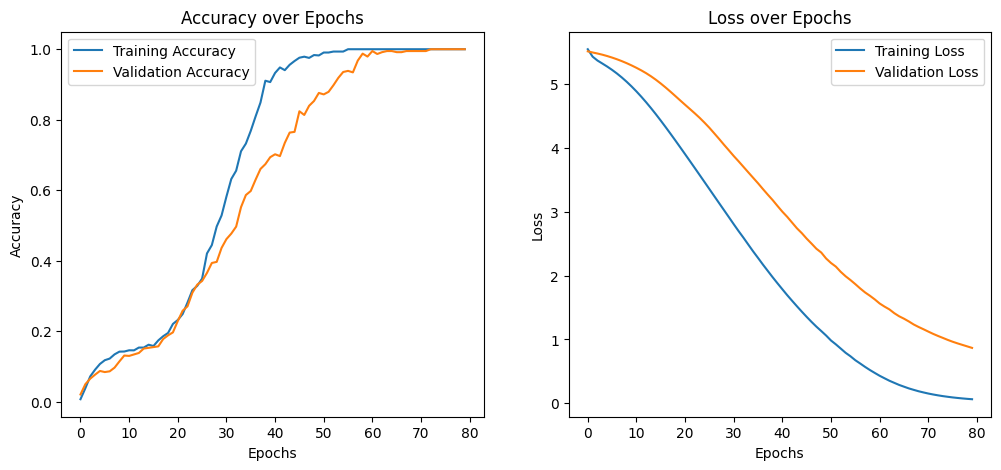

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 1.0000 - loss: 0.0636 - val_accuracy: 1.0000 - val_loss: 0.8671
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 0.8516
Test Loss: 0.8542, Test Accuracy: 1.0000


In [ ]:
# @title Default title text

# Set random seed for reproducibility
np.random.seed(42)


# Dataset Parameters
N = 4  # Number of channel uses
K = 8  # Block size (log2 of the number of messages)
M = 2**K  # Number of possible messages (2^K)
batch_size = 6400
output = 2**K
Eb_No = 15  # Signal-to-Noise ratio in dB

# Create Dataset with Integer Labels
train_dataset = np.tile(np.arange(M), batch_size // M)
test_dataset = np.tile(np.arange(M), batch_size  //(2*M))

# Shuffle the dataset
np.random.shuffle(train_dataset)
np.random.shuffle(test_dataset)

# Define split ratios
train_ratio = 0.85  # 85% for training
val_ratio = 0.15    # 15% for validation

# Calculate the number of samples
num_train_samples = int(len(train_dataset) * train_ratio)
num_val_samples = len(train_dataset) - num_train_samples

# Split the datasets
train_set = train_dataset[:num_train_samples]
val_set = train_dataset[num_train_samples:]

# Reshape the datasets if needed
train_set = train_set.reshape((-1, 1))
val_set = val_set.reshape((-1, 1))
test_dataset = test_dataset.reshape((-1, 1))

# Print dataset sizes
print(f"Number of train samples: {len(train_set)}")
print(f"Number of validation samples: {len(val_set)}")
print(f"Number of test samples: {len(test_dataset)}")



# Custom Noise Layer
class CustomNoise(tf.keras.layers.Layer):
    def __init__(self, mean=0.0, stddev=10**(-1.0*Eb_No), **kwargs):
        super(CustomNoise, self).__init__(**kwargs)
        self.mean = mean
        self.stddev = stddev

    def call(self, inputs):
        noise = tf.random.normal(shape=tf.shape(inputs), mean=self.mean, stddev=self.stddev)
        return inputs + noise

# class Normalization(tf.keras.layers.Layer):
#     def __init__(self, **kwargs):
#         super(Normalization, self).__init__(**kwargs)

#     def call(self, input):
#         out = tf.nn.l2_normalize(tf.reshape(input, (-1, 2)), axis=-1, epsilon=1e-6)
#         out = tf.reshape(out, (-1, 2*N))
#         print("normalization layer output shape:" ,str(out.shape))
#         return out
#     def get_config(self):
#         config = super(Normalization, self).get_config()
#         return config


class Normalization(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(Normalization, self).__init__(**kwargs)

    def call(self, input):
        # Perform L2 normalization on the last dimension while keeping the overall shape
        print(input)
        out = tf.nn.l2_normalize(input, axis=-1, epsilon=1e-6)
        # print("Normalization layer output shape:", out.shape)
        return out

    def get_config(self):
        config = super(Normalization, self).get_config()
        return config

class PowerConstraintLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(PowerConstraintLayer, self).__init__(**kwargs)

    def call(self, inputs):
        # Split real and imaginary parts
        real_parts = inputs[:,:, :4]  # First 4 elements
        imag_parts = inputs[:,:, 4:]  # Last 4 elements

        # Compute magnitudes
        magnitudes = tf.sqrt(tf.square(real_parts) + tf.square(imag_parts))

        # Find the maximum magnitude
        #max_magnitude = tf.reduce_max(magnitudes, axis=1, keepdims=True)

        # Scale inputs if max magnitude > 1
        # Replace zero values with one
        scale_factor = tf.where(tf.less_equal(magnitudes, 1), tf.ones_like(magnitudes), magnitudes)
        scale_factor = tf.concat([scale_factor, scale_factor],axis=-1)
        scaled_inputs = inputs / scale_factor

        return scaled_inputs

    def get_config(self):
        config = super(PowerConstraintLayer, self).get_config()
        return config


class SD(tf.keras.layers.Layer):
    def __init__(self, l=6, n=4, r=4, **kwargs):
        super(SD, self).__init__(**kwargs)
        self.l = l
        self.n = n
        self.r = r

        with tf.name_scope("fe"):
            self.fe = Sequential([
                Dense(64, activation='relu', name='initial'),
                Dense(8, activation='linear', name='feature_extractor')
            ])

        with tf.name_scope("pe"):
            self.pe = Sequential([
                Dense(64, activation='relu', name='initial'),
                Dense(2, activation='linear', name='phase_estimator')
            ])

        with tf.name_scope("oe"):
            self.oe = Sequential([
                Dense(64, activation='relu', name='initial'),
                Dense(64, activation='relu', name='oe_dense1'),
                Dense(32, activation='relu', name='oe_dense2'),
                Dense(1, activation='linear', name='offset_estimator'),

            ])

    def mini_slicer(self, inputs):
        in_dim = tf.shape(inputs)[1]
        N_msg = self.r * self.n
        l1 = 1 + (self.l - 1) * N_msg - self.r
        l2 = self.l * N_msg + self.r
        out_1 = inputs[:, l1-1:l2]
        out_2 = inputs[:, in_dim // 2 + l1-1:in_dim // 2 + l2]
        output = tf.concat([out_1, out_2], axis=1)
        print('mini slice output shape', output.shape)
        return output

    def call(self, inputs):
        # Get the input dimension (before slicing)
        in_dim = inputs.shape[1]

        # Process the inputs using mini_slicer (this changes the shape of inputs)
        # inputs = self.mini_slicer(inputs)

        # Update real and imag slices based on new input shape (after mini_slicer)
        half_dim = tf.shape(inputs)[1] // 2  # Get new half dimension after slicing
        real = inputs[:, :half_dim]  # First half of sliced inputs as real part
        imag = inputs[:, half_dim:]  # Second half as imaginary part

        # Pass the sliced inputs to the phase estimator model to get h
        h = self.pe(inputs)  # h has shape (batch_size, 2)
        h_real = h[:, 0]  # Extract real part of h
        h_imag = h[:, 1]  # Extract imaginary part of h

        h_real = tf.expand_dims(h_real, axis=1)
        h_imag = tf.expand_dims(h_imag, axis=1)

        # # Perform element-wise multiplication
        # h_real_ex = tf.tile(h_real, [1, half_dim])
        # h_imag_ex = tf.tile(h_imag, [1, half_dim])
        # real_mul = real * h_real_ex -imag*h_imag_ex # Multiply same value of real part to every component of the input
        # imag_mul = real * h_imag_ex + imag*h_real_ex # Multiply same value of imag part to every component of the input

        # Apply the feature extractor model to real_mul (as an example)
        feature_extract_output = self.fe(inputs)
        offset_estimator_output = self.oe(inputs)

        # Concatenate the outputs
        output = tf.concat([real, imag,offset_estimator_output,h_real,h_imag, feature_extract_output], axis=1)

        return output


class SD_RNN(tf.keras.layers.Layer):
    def __init__(self, l=6, n=4, r=4, units=16, **kwargs):
        super(SD_RNN, self).__init__(**kwargs)
        self.l = l
        self.n = n
        self.r = r
        self.units = units  # RNN units

        with tf.name_scope("fe"):
            # Use LSTM or GRU for feature extractor
            self.fe = Sequential([
                Reshape((1, 92)),
                LSTM(self.units, return_sequences=True, name='feature_extractor_lstm'),
                Flatten(),# or use GRU
                Dense(8, activation='linear', name='feature_extractor_output')
            ])

        with tf.name_scope("pe"):
            # Use LSTM or GRU for phase estimator
            self.pe = Sequential([
                Reshape((1, 92)),
                LSTM(self.units, return_sequences=True, name='phase_estimator_lstm'),
                Flatten(),# or use GRU
                Dense(2, activation='linear', name='phase_estimator_output')
            ])

        with tf.name_scope("oe"):
            self.oe = Sequential([
                 Reshape((1, 92)),
                LSTM(self.units, return_sequences=True, name='offset_estimator_lstm'),
                LSTM(self.units, return_sequences=True, name='offset_estimator_lstm1'),
                LSTM(self.units//2, return_sequences=True, name='offset_estimator_lstm2'),
                Flatten(),
                Dense(1, activation='linear', name='offset_estimator'),

            ])



    def mini_slicer(self, inputs):
        in_dim = tf.shape(inputs)[1]
        N_msg = self.r * self.n
        l1 = 1 + (self.l - 1) * N_msg - self.r
        l2 = self.l * N_msg + self.r
        out_1 = inputs[:, l1-1:l2]
        out_2 = inputs[:, in_dim // 2 + l1-1:in_dim // 2 + l2]
        output = tf.concat([out_1, out_2], axis=1)
        print('mini slice output shape', output.shape)
        return output

    def call(self, inputs):
        # Get the input dimension (before slicing)
        in_dim = inputs.shape[1]

        # Process the inputs using mini_slicer (this changes the shape of inputs)
        # inputs = self.mini_slicer(inputs)

        # Update real and imag slices based on new input shape (after mini_slicer)
        half_dim = tf.shape(inputs)[1] // 2  # Get new half dimension after slicing
        real = inputs[:, :half_dim]  # First half of sliced inputs as real part
        imag = inputs[:, half_dim:]  # Second half as imaginary part

        # Pass the sliced inputs to the phase estimator model to get h
        h = self.pe(inputs)  # h has shape (batch_size, 2)
        h_real = h[:, 0]  # Extract real part of h
        h_imag = h[:, 1]  # Extract imaginary part of h

        h_real = tf.expand_dims(h_real, axis=1)
        h_imag = tf.expand_dims(h_imag, axis=1)



        # # Perform element-wise multiplication
        # h_real_ex = tf.tile(h_real, [1, half_dim])
        # h_imag_ex = tf.tile(h_imag, [1, half_dim])
        # real_mul = real * h_real_ex -imag*h_imag_ex # Multiply same value of real part to every component of the input
        # imag_mul = real * h_imag_ex + imag*h_real_ex # Multiply same value of imag part to every component of the input

        # Apply the feature extractor model to real_mul (as an example)
        feature_extract_output = self.fe(inputs)
        offset_estimator_output = self.oe(inputs)

        # Concatenate the outputs
        output = tf.concat([real, imag,offset_estimator_output,h_real,h_imag, feature_extract_output], axis=1)

        return output



class StochasticChannelv3(tf.keras.layers.Layer):
    def __init__(self, roll_off=0.35, num_taps=31, time_delay=0, r=4, ts=1, **kwargs):
        super(StochasticChannelv3, self).__init__(**kwargs)
        self.num_taps = num_taps
        self.time_delay = time_delay
        self.r = r  # Upsampling factor
        self.roll_off = roll_off  # Roll-off factor
        self.ts = ts  # Sampling period (default is 1)

    def upsampling(self, inp):
        com_reshape = tf.reshape(inp, [-1, 1])
        padding = tf.constant([[0, 0], [0, self.r - 1]])  # Access self.r
        upsampled = tf.pad(com_reshape, padding, mode="CONSTANT")
        upsampled = tf.reshape(upsampled, [-1])  # Flatten back to 1D
        return upsampled

    def upsample_iq(self, inp):
        real = inp[:, 0]  # Real part
        imag = inp[:, 1]  # Imaginary part

        real_up = self.upsampling(real)
        imag_up = self.upsampling(imag)

        upsampled = tf.stack([real_up, imag_up], axis=1)
        return upsampled

    def rrc_filter(self):
        t = np.linspace(-self.num_taps // 2, self.num_taps // 2 + 1, self.num_taps) - self.time_offset()
        rrc = np.zeros_like(t)

        for i in range(len(t)):
            if t[i] == 0.0:
                rrc[i] = (1.0 - self.roll_off + 4 * self.roll_off / np.pi) / self.ts
            elif np.abs(t[i]) == self.ts / (4 * self.roll_off):
                rrc[i] = (self.roll_off / (np.sqrt(2) * self.ts)) * \
                         ((1 + 2 / np.pi) * np.sin(np.pi / (4 * self.roll_off)) +
                          (1 - 2 / np.pi) * np.cos(np.pi / (4 * self.roll_off)))
            else:
                rrc[i] = (np.sin(np.pi * (t[i] / self.ts) * (1 - self.roll_off)) +
                          4 * self.roll_off * (t[i] / self.ts) * np.cos(np.pi * (t[i] / self.ts) * (1 + self.roll_off))) / \
                         (np.pi * t[i] * (1 - (4 * self.roll_off * (t[i] / self.ts)) ** 2))

        rrc = rrc / np.sqrt(np.sum(rrc ** 2))
        rrc = tf.constant(rrc, dtype=tf.float32)
        return rrc

    def phase_offset(self):
        phase_offset = np.random.uniform(0, (2) * np.pi)
        return phase_offset

    def upsample_and_filter(self, signal):
        upsampled_signal = self.upsample_iq(signal)
        rrc = self.rrc_filter()

        upsampled_signal = tf.expand_dims(upsampled_signal, axis=0)  # Shape: (1, length, 2)
        rrc = tf.reshape(rrc, [-1, 1, 1])  # Shape: (filter_length, 1, 1)

        padding_size = self.num_taps // 2
        paddings = tf.constant([[0, 0], [padding_size, padding_size], [0, 0]])
        padded_real = tf.pad(upsampled_signal[:, :, 0:1], paddings, "CONSTANT")
        padded_imag = tf.pad(upsampled_signal[:, :, 1:2], paddings, "CONSTANT")
        upsampled_signal = tf.concat([padded_real, padded_imag], axis=2)

        real_filtered = tf.nn.conv1d(upsampled_signal[:, :, 0:1], rrc, stride=1, padding='SAME')
        imag_filtered = tf.nn.conv1d(upsampled_signal[:, :, 1:2], rrc, stride=1, padding='SAME')


        real_filtered = real_filtered * tf.math.cos(self.phase_offset())-imag_filtered * tf.math.sin(self.phase_offset())
        imag_filtered = imag_filtered * tf.math.sin(self.phase_offset())+real_filtered * tf.math.cos(self.phase_offset())

        filtered_signal = tf.concat([real_filtered, imag_filtered], axis=2)
        filtered_signal = tf.squeeze(filtered_signal, axis=0)  # Remove the batch dimension
        return filtered_signal

    def time_offset(self, sampling_time=0.5e-6):
        t_offset = np.random.uniform(-sampling_time , sampling_time )
        return t_offset


    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        f = inputs.shape[1] // 2

        # Reshape to pairs of real and imaginary parts
        inputs = tf.reshape(inputs, [batch_size, -1, 2])  # Shape: (batch_size, num_pairs, 2) adjacent pairs are couples as real imaginary
        print(inputs.shape)
        # Define a function to process each sample
        def process_sample(sample):
            filtered_signal = self.upsample_and_filter(sample)  # Process each sample
            return filtered_signal

        # Apply the function to each sample in the batch
        output = tf.map_fn(process_sample, inputs, dtype=tf.float32)  # Shape: (batch_size, num_filtered_samples, 2)

        # Reshape back to original shape if necessary
        output = tf.reshape(output, [batch_size, -1])

        return output

# Autoencoder Class with Convolutional Layers
class AE:
    def __init__(self, train_data, val_data, test_data, input_dim=K, enc_dim=N, act_fun='relu'):
        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data
        self.input_dim = input_dim
        self.enc_dim = enc_dim
        self.act_fun = act_fun


    def AE_implement(self):
        autoencoder = Sequential([
            Input(shape=(1,),batch_size = batch_size),  # Add this input layer
            # Embedding Layer (Input: message indices)
            Embedding(input_dim=M, output_dim=256, input_length=1, name="Embedding"),
            Flatten(),  # Flatten output to feed into Conv1D layers

            # Encoder (Multiple Conv1D layers)
            Reshape((1, 256)),  # Reshape for Conv1D
            Conv1D(256, kernel_size=1, activation='elu', name="Conv1D_1"),
            Conv1D(128, kernel_size=1, activation='elu', name="Conv1D_2"),
            Conv1D(64, kernel_size=1, activation='elu', name="Conv1D_3"),
            Conv1D(2*N, kernel_size=1, activation='linear', name="Conv1D_4"),

            # # Power Normalization Layer (L2 normalization over 2N dimensions)
            # tf.keras.layers.Lambda(lambda x: tf.nn.l2_normalize(x, axis=-1)),
            # PowerConstraintLayer(input_shape=(1, 8),name= "power"),
            Normalization(input_shape=(1, 8),name= "normal"),
            # Custom Noise Layer (Simulating the channel)
            StochasticChannelv3(name="StochasticChannel"),
            CustomNoise(name="NoiseLayer"),
            SD_RNN(name="SD"),

            Reshape((1, 103)),  # Reshape for Conv1D_dec1
            # Decoder (Conv1D layers to reconstruct the input)
            Conv1D(64, kernel_size=1, activation='elu', name="Conv1D_Dec1"),
            Conv1D(128, kernel_size=1, activation='elu', name="Conv1D_Dec2"),
            Conv1D(256, kernel_size=1, activation='elu', name="Conv1D_Dec3"),

            # Output Layer with Softmax to predict the message index
            Flatten(),
            Dense(output, activation='softmax', name="Output")
        ],name="Autoencoder_Model",)

        # Compile the model
        autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,beta_1=0.9, beta_2=0.999,epsilon=1e-07),
                            loss='sparse_categorical_crossentropy',
                            metrics=['accuracy'])
        return autoencoder


        # Training Class with Early Stopping and Plotting
    def train(self, epochs=40, batch_size=32):
        autoencoder = self.AE_implement()

        log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

        history = autoencoder.fit(self.train_data, self.train_data,
                                  epochs=epochs, batch_size=batch_size,
                                  validation_data=(self.val_data, self.val_data),
                                  callbacks=[PlottingCallback(), tensorboard_callback])
        return autoencoder, history


# Custom Callback for Real-time Plotting
class PlottingCallback(Callback):
    def __init__(self):
        super(PlottingCallback, self).__init__()
        self.history = {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}

    def on_epoch_end(self, epoch, logs=None):
        self.history['accuracy'].append(logs.get('accuracy'))
        self.history['val_accuracy'].append(logs.get('val_accuracy'))
        self.history['loss'].append(logs.get('loss'))
        self.history['val_loss'].append(logs.get('val_loss'))

        clear_output(wait=True)

        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(self.history['accuracy'], label='Training Accuracy')
        plt.plot(self.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Accuracy over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(self.history['loss'], label='Training Loss')
        plt.plot(self.history['val_loss'], label='Validation Loss')
        plt.title('Loss over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.show()



# Instantiate and Train
ae = AE(train_data=train_set, val_data=val_set, test_data=test_dataset, input_dim=K, enc_dim=N, act_fun='tanh')
autoencoder_model, history = ae.train(epochs=80, batch_size=batch_size)

# Evaluate the model
loss, accuracy = autoencoder_model.evaluate(test_dataset, test_dataset)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")


In [ ]:
# Save the model for MATLAB
autoencoder_model.save('my_model.keras')  # Save in HDF5 format
#autoencoder_model.save('autoencoder_model.tf')  # Save in SavedModel format

In [ ]:
autoencoder_model.save('my_model.h5')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
autoencoder_model.summary()


Model: "Autoencoder_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Embedding (Embedding)                │ (6400, 1, 256)              │          65,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (6400, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (6400, 1, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv1D_1 (Conv1D)                    │ (6400, 1, 256)              │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv1D_2 (Conv1D)                    │ (6400, 1, 128)              │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv1D_3 (Conv1D)                    │ (6400, 1, 64)               │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv1D_4 (Conv1D)                    │ (6400, 1, 8)                │             520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ power (PowerConstraintLayer)         │ (6400, 1, 8)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normal (Normalization)               │ (6400, 1, 8)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ StochasticChannel                    │ (6400, 92)                  │               0 │
│ (StochasticChannelv3)                │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ NoiseLayer (CustomNoise)             │ (6400, 92)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ SD (SD_RNN)                          │ (6400, 103)                 │          24,019 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_4 (Reshape)                  │ (6400, 1, 103)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv1D_Dec1 (Conv1D)                 │ (6400, 1, 64)               │           6,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv1D_Dec2 (Conv1D)                 │ (6400, 1, 128)              │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv1D_Dec3 (Conv1D)                 │ (6400, 1, 256)              │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (6400, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (6400, 256)                 │          65,792 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 932,435 (3.56 MB)

 Trainable params: 310,811 (1.19 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 621,624 (2.37 MB)

In [ ]:
from tensorflow.keras.models import Model

# Get the output of the Normalization layer
sub_model_output = autoencoder_model.get_layer("normal").output
sub_model_output_p = autoencoder_model.get_layer("power").output

# Create a new model from the input to the Normalization layer
sub_model = Model(inputs=autoencoder_model.input, outputs=sub_model_output)
sub_model_p = Model(inputs=autoencoder_model.input, outputs=sub_model_output_p)

# Display the summary of the sub-model
sub_model.summary()
sub_model_p.summary()


ValueError: The layer Autoencoder_Model has never been called and thus has no defined input.

# Save encoder output as a .mat file

In [ ]:
from scipy.io import savemat

sub_model_output_values = sub_model.predict(train_dataset)  # Use predict to get NumPy values
sub_model_output_values = tf.squeeze(sub_model_output_values, axis=1)

sub_model_output_p_values = sub_model_p.predict(train_dataset)  # Use predict to get NumPy values
sub_model_output_p_values = tf.squeeze(sub_model_output_p_values, axis=1)

# Since eager execution is enabled, you can directly get the tensor values
sub_model_output_p_values = sub_model_output_p_values.numpy()
sub_model_output_values = sub_model_output_values.numpy()
print(sub_model_output_values)

# Save the result to a .mat file
savemat("Tx_out_n4_k8.mat", {"data": sub_model_output_values})
savemat("Tx_out_n4_k8_p.mat", {"data": sub_model_output_p_values})

# Create complex data using NumPy
complex_data = sub_model_output_values[:, :4] + 1j * sub_model_output_values[:, 4:]
complex_data_p = sub_model_output_p_values[:, :4] + 1j * sub_model_output_p_values[:, 4:]

# Save complex data to .mat file
savemat("Tx_out_complex_n4_k8.mat", {"data": complex_data})
savemat("Tx_out_complex_n4_k8_p.mat", {"data": complex_data_p})  # Save complex_data_p as well

print("Saved tensor data as a .mat file.")

In [ ]:
sub_model.save('my_Submodel.keras')
sub_model.save('my_Submodel.h5')

In [ ]:
def BLER(test_dataset, frame_size, model):
    prediction = model.predict(test_dataset)
    total_blocks = prediction.shape[0] // frame_size
    print(total_blocks)
    print(prediction.shape)
    print(test_dataset.shape)
    prediction = np.argmax(prediction, axis=1)
    test_dataset = test_dataset.ravel()
    print(prediction.shape)
    print(test_dataset[:frame_size])
    print(prediction[0:frame_size])

    bler = 0
    for i in range(total_blocks):
        block_prediction = prediction[i * frame_size : (i + 1) * frame_size]
        block_true = test_dataset[i * frame_size : (i + 1) * frame_size]

        if not np.array_equal(block_prediction, block_true):  # Corrected comparison
            bler += 1

    return bler / total_blocks

bler = BLER(test_dataset[:20001], 100, autoencoder_model)
print(bler)

# CNN Bsed AE for CTS transmission

## Sliding window


In [ ]:
class SlidingWindowConcatLayer(tf.keras.layers.Layer):
    def __init__(self, window_size, **kwargs):
        """
        Initialize the SlidingWindowConcatLayer.

        Args:
            window_size (int): Number of rows in the sliding window.
        """
        super(SlidingWindowConcatLayer, self).__init__(**kwargs)
        self.window_size = window_size

    def call(self, inputs):
        """
        Apply the sliding window and concatenation operation to the inputs.

        Args:
            inputs (tf.Tensor): A 3D tensor of shape (rows, cols, depth).

        Returns:
            tf.Tensor: A transformed tensor after sliding window and concatenation.
        """
        # Determine padding size
        paddings = [[self.window_size // 2, self.window_size // 2], [0, 0], [0, 0]]

        # Pad the input tensor
        padded_matrix = tf.pad(inputs, paddings=paddings, mode="CONSTANT", constant_values=0)

        # Initialize a list to store the new rows
        new_matrix_list = []
        batch_size = tf.shape(inputs)[0]

        # Create sliding windows and concatenate along the depth
        for i in range(batch_size):  # Iterate over the original matrix row count
            window = padded_matrix[i:i + self.window_size]
            concatenated_row = tf.concat(tf.unstack(window, axis=0), axis=-1)
            new_matrix_list.append(concatenated_row)

        # Stack the resulting rows into a single tensor
        output = tf.stack(new_matrix_list)
        return output

    def get_config(self):
        """
        Returns the configuration of the layer for serialization.
        """
        config = super(SlidingWindowConcatLayer, self).get_config()
        config.update({"window_size": self.window_size})
        return config

original_matrix = tf.random.uniform(shape=(20, 1, 8), minval=0, maxval=10, dtype=tf.int32)
sliding_window_layer = SlidingWindowConcatLayer(window_size=13)
new_matrix = sliding_window_layer(original_matrix)

print("Original Matrix Shape:", original_matrix.shape)
print("New Matrix Shape:", new_matrix.shape)

Original Matrix Shape: (20, 1, 8)
New Matrix Shape: (20, 1, 104)


In [ ]:
class SlidingWindowConcatLayer1(tf.keras.layers.Layer):
    def __init__(self, window_size, **kwargs):
        """
        Initialize the SlidingWindowConcatLayer.

        Args:
            window_size (int): Number of rows in the sliding window.
        """
        super(SlidingWindowConcatLayer1, self).__init__(**kwargs)
        self.window_size = window_size

    def call(self, inputs):
        """
        Apply the sliding window and concatenation operation to the inputs.

        Args:
            inputs (tf.Tensor): A 3D tensor of shape (batch_size, rows, depth).

        Returns:
            tf.Tensor: A transformed tensor after sliding window and concatenation.
        """
        batch_size = tf.shape(inputs)[0]
        rows = tf.shape(inputs)[1]
        depth = tf.shape(inputs)[2]

        # Pad the input tensor
        paddings = [[0, 0], [self.window_size // 2, self.window_size // 2], [0, 0]]
        padded_matrix = tf.pad(inputs, paddings=paddings, mode="CONSTANT", constant_values=0)

        # Create sliding windows
        window_slices = [
            padded_matrix[:, i:i + rows, :]
            for i in range(self.window_size)
        ]

        # Concatenate windows along the depth dimension
        concatenated = tf.concat(window_slices, axis=-1)
        return concatenated

    def compute_output_shape(self, input_shape):
        """
        Compute the output shape of the layer.
        """
        batch_size, rows, depth = input_shape
        output_depth = depth * self.window_size
        return (batch_size, rows, output_depth)

    def get_config(self):
        """
        Returns the configuration of the layer for serialization.
        """
        config = super(SlidingWindowConcatLayer1, self).get_config()
        config.update({"window_size": self.window_size})
        return config


original_matrix = tf.random.uniform(shape=(20, 1, 8), minval=0, maxval=10, dtype=tf.int32)
sliding_window_layer = SlidingWindowConcatLayer1(window_size=13)
new_matrix = sliding_window_layer(original_matrix)

print("Original Matrix Shape:", original_matrix.shape)
print("New Matrix Shape:", new_matrix.shape)


Original Matrix Shape: (20, 1, 8)
New Matrix Shape: (20, 1, 104)


##Stochastic channel

In [ ]:
##- taking adjacent as real and imaginary pairs


class StochasticChannelv3(tf.keras.layers.Layer):
    def __init__(self, roll_off=0.35, num_taps=31, time_delay=0, r=4, ts=1, **kwargs):
        super(StochasticChannelv3, self).__init__(**kwargs)
        self.num_taps = num_taps
        self.time_delay = time_delay
        self.r = r  # Upsampling factor
        self.roll_off = roll_off  # Roll-off factor
        self.ts = ts  # Sampling period (default is 1)

    def upsampling(self, inp):
        com_reshape = tf.reshape(inp, [-1, 1])
        padding = tf.constant([[0, 0], [0, self.r - 1]])  # Access self.r
        upsampled = tf.pad(com_reshape, padding, mode="CONSTANT")
        upsampled = tf.reshape(upsampled, [-1])  # Flatten back to 1D
        return upsampled

    def upsample_iq(self, inp):
        real = inp[:, 0]  # Real part
        imag = inp[:, 1]  # Imaginary part

        real_up = self.upsampling(real)
        imag_up = self.upsampling(imag)

        upsampled = tf.stack([real_up, imag_up], axis=1)
        return upsampled

    def rrc_filter(self):
        t = np.linspace(-self.num_taps // 2, self.num_taps // 2 + 1, self.num_taps) - self.time_offset()
        rrc = np.zeros_like(t)

        for i in range(len(t)):
            if t[i] == 0.0:
                rrc[i] = (1.0 - self.roll_off + 4 * self.roll_off / np.pi) / self.ts
            elif np.abs(t[i]) == self.ts / (4 * self.roll_off):
                rrc[i] = (self.roll_off / (np.sqrt(2) * self.ts)) * \
                         ((1 + 2 / np.pi) * np.sin(np.pi / (4 * self.roll_off)) +
                          (1 - 2 / np.pi) * np.cos(np.pi / (4 * self.roll_off)))
            else:
                rrc[i] = (np.sin(np.pi * (t[i] / self.ts) * (1 - self.roll_off)) +
                          4 * self.roll_off * (t[i] / self.ts) * np.cos(np.pi * (t[i] / self.ts) * (1 + self.roll_off))) / \
                         (np.pi * t[i] * (1 - (4 * self.roll_off * (t[i] / self.ts)) ** 2))

        rrc = rrc / np.sqrt(np.sum(rrc ** 2))
        rrc = tf.constant(rrc, dtype=tf.float32)
        return rrc

    def phase_offset(self):
        phase_offset = np.random.uniform(0, (2) * np.pi)
        return phase_offset

    def upsample_and_filter(self, signal):
        upsampled_signal = self.upsample_iq(signal)
        rrc = self.rrc_filter()

        upsampled_signal = tf.expand_dims(upsampled_signal, axis=0)  # Shape: (1, length, 2)
        rrc = tf.reshape(rrc, [-1, 1, 1])  # Shape: (filter_length, 1, 1)

        padding_size = self.num_taps // 2
        paddings = tf.constant([[0, 0], [padding_size, padding_size], [0, 0]])
        padded_real = tf.pad(upsampled_signal[:, :, 0:1], paddings, "CONSTANT")
        padded_imag = tf.pad(upsampled_signal[:, :, 1:2], paddings, "CONSTANT")
        upsampled_signal = tf.concat([padded_real, padded_imag], axis=2)

        real_filtered = tf.nn.conv1d(upsampled_signal[:, :, 0:1], rrc, stride=1, padding='SAME')
        imag_filtered = tf.nn.conv1d(upsampled_signal[:, :, 1:2], rrc, stride=1, padding='SAME')


        real_filtered = real_filtered * tf.math.cos(self.phase_offset())-imag_filtered * tf.math.sin(self.phase_offset())
        imag_filtered = imag_filtered * tf.math.sin(self.phase_offset())+real_filtered * tf.math.cos(self.phase_offset())

        filtered_signal = tf.concat([real_filtered, imag_filtered], axis=2)
        filtered_signal = tf.squeeze(filtered_signal, axis=0)  # Remove the batch dimension
        return filtered_signal

    def time_offset(self, sampling_time=0.5e-6):
        t_offset = np.random.uniform(-sampling_time , sampling_time )
        return t_offset


    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        f = inputs.shape[1] // 2

        # Reshape to pairs of real and imaginary parts
        inputs = tf.reshape(inputs, [batch_size, -1, 2])  # Shape: (batch_size, num_pairs, 2)
        print(inputs.shape)
        # Define a function to process each sample
        def process_sample(sample):
            filtered_signal = self.upsample_and_filter(sample)  # Process each sample
            return filtered_signal

        # Apply the function to each sample in the batch
        output = tf.map_fn(process_sample, inputs, dtype=tf.float32)  # Shape: (batch_size, num_filtered_samples, 2)

        # Reshape back to original shape if necessary
        output = tf.reshape(output, [batch_size, -1])

        return output

##Datasets

In [ ]:
# Set random seed for reproducibility
np.random.seed(42)


# Dataset Parameters
N = 4  # Number of channel uses
K = 8  # Block size (log2 of the number of messages)
M = 2**K  # Number of possible messages (2^K)
batch_size = 6400
output = 2**K
Eb_No = 15  # Signal-to-Noise ratio in dB

# Create Dataset with Integer Labels
train_dataset = np.tile(np.arange(M), batch_size // M)
test_dataset = np.tile(np.arange(M), batch_size  //(2*M))

# Shuffle the dataset
np.random.shuffle(train_dataset)
np.random.shuffle(test_dataset)

# Define split ratios
train_ratio = 0.85  # 85% for training
val_ratio = 0.15    # 15% for validation

# Calculate the number of samples
num_train_samples = int(len(train_dataset) * train_ratio)
num_val_samples = len(train_dataset) - num_train_samples

# Split the datasets
train_set = train_dataset[:num_train_samples]
val_set = train_dataset[num_train_samples:]

# Reshape the datasets if needed
train_set = train_set.reshape((-1, 1))
val_set = val_set.reshape((-1, 1))
test_dataset = test_dataset.reshape((-1, 1))

# Pad the test dataset with 6 zeros before and after
padding = np.zeros((6, 1), dtype=int)
train_set_padded = np.vstack([padding, train_set, padding])
val_set_padded = np.vstack([padding, val_set, padding])
test_dataset_padded = np.vstack([padding, test_dataset, padding])

# Print dataset sizes
print(f"Number of train samples: {len(train_set)}")
print(f"Number of validation samples: {len(val_set)}")
print(f"Number of test samples: {len(test_dataset)}")
print(f"Number of train samples padded: {len(train_set_padded)}")
print(f"Number of validation samples padded: {len(val_set_padded)}")
print(f"Number of test samples padded: {len(test_dataset_padded)}")

Number of train samples: 5440
Number of validation samples: 960
Number of test samples: 3072
Number of train samples padded: 5452
Number of validation samples padded: 972
Number of test samples padded: 3084


##Custom Noise, Normalization layer

In [ ]:
# Custom Noise Layer
class CustomNoise(tf.keras.layers.Layer):
    def __init__(self, mean=0.0, stddev=10**(-1.0*Eb_No), **kwargs):
        super(CustomNoise, self).__init__(**kwargs)
        self.mean = mean
        self.stddev = stddev

    def call(self, inputs):
        noise = tf.random.normal(shape=tf.shape(inputs), mean=self.mean, stddev=self.stddev)
        return inputs + noise

# class Normalization(tf.keras.layers.Layer):
#     def __init__(self, **kwargs):
#         super(Normalization, self).__init__(**kwargs)

#     def call(self, input):
#         out = tf.nn.l2_normalize(tf.reshape(input, (-1, 2)), axis=-1, epsilon=1e-6)
#         out = tf.reshape(out, (-1, 2*N))
#         print("normalization layer output shape:" ,str(out.shape))
#         return out
#     def get_config(self):
#         config = super(Normalization, self).get_config()
#         return config


class Normalization(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(Normalization, self).__init__(**kwargs)

    def call(self, input):
        # Perform L2 normalization on the last dimension while keeping the overall shape
        out = tf.nn.l2_normalize(input, axis=-1, epsilon=1e-6)
        # print("Normalization layer output shape:", out.shape)
        return out

    def get_config(self):
        config = super(Normalization, self).get_config()
        return config




##Sequence Decoder

In [ ]:
class SD(tf.keras.layers.Layer):
    def __init__(self, l=6, n=4, r=4, **kwargs):
        super(SD, self).__init__(**kwargs)
        self.l = l
        self.n = n
        self.r = r

        with tf.name_scope("fe"):
            self.fe = Sequential([
                Dense(256, activation='relu', name='initial'),
                Dense(8, activation='linear', name='feature_extractor')
            ])

        with tf.name_scope("pe"):
            self.pe = Sequential([
                Dense(256, activation='relu', name='initial'),
                Dense(128, activation='relu', name='phase_estimator_dense1'),
                Dense(2, activation='linear', name='phase_estimator')
            ])

        with tf.name_scope("oe"):
            self.oe = Sequential([
                Dense(256, activation='relu', name='initial'),
                Dense(128, activation='relu', name='oe_dense1'),
                Dense(32, activation='relu', name='oe_dense2'),
                Dense(16, activation='softmax', name='offset_estimator'),

            ])

    def mini_slicer(self, inputs):
        # in_dim = tf.shape(inputs)[1]
        N_msg = self.r * self.n
        l1 = 30 + (self.l) *2* N_msg #- self.r,   here 30 is number of paddings, since num_taps=31 (num_taps//2)*2
        l2 = 30 + (self.l+1) *2* N_msg
        # out_1 = inputs[:, l1-1:l2]
        # out_2 = inputs[:, in_dim // 2 + l1-1:in_dim // 2 + l2]
        # output = tf.concat([out_1, out_2], axis=1)
        output = inputs[:, l1:l2]
        print('mini slice output shape', output.shape)
        return output

    def call(self, inputs):
        # Get the input dimension (before slicing)
        bs = inputs.shape[0]

        # inputs = tf.reshape(inputs,[bs,-1,2])
        # real = inputs[:, :, 0]  # Real part
        # imag = inputs[:, :, 1]  # Imaginary part

        # Process the inputs using mini_slicer (this changes the shape of inputs)

        # # Update real and imag slices based on new input shape (after mini_slicer)
        # half_dim = tf.shape(inputs)[1] // 2  # Get new half dimension after slicing
        # real = inputs[:, :half_dim]  # First half of sliced inputs as real part
        # imag = inputs[:, half_dim:]  # Second half as imaginary part

        # Pass the sliced inputs to the phase estimator model to get h
        h = self.pe(inputs)  # h has shape (batch_size, 2)
        h_real = h[:, 0]  # Extract real part of h
        h_imag = h[:, 1]  # Extract imaginary part of h

        h_real = tf.expand_dims(h_real, axis=1)
        h_imag = tf.expand_dims(h_imag, axis=1)

        # # Perform element-wise multiplication
        # h_real_ex = tf.tile(h_real, [1, half_dim])
        # h_imag_ex = tf.tile(h_imag, [1, half_dim])
        # real_mul = real * h_real_ex -imag*h_imag_ex # Multiply same value of real part to every component of the input
        # imag_mul = real * h_imag_ex + imag*h_real_ex # Multiply same value of imag part to every component of the input

        # Apply the feature extractor model to real_mul (as an example)
        feature_extract_output = self.fe(inputs)
        offset_estimator_output = self.oe(inputs)
        mini_inputs = self.mini_slicer(inputs)

        # Concatenate the outputs
        output = tf.concat([mini_inputs,h, feature_extract_output,offset_estimator_output], axis=1)

        return output


class SD_RNN(tf.keras.layers.Layer):
    def __init__(self, l=6, n=4, r=4, units=16, **kwargs):
        super(SD_RNN, self).__init__(**kwargs)
        self.l = l
        self.n = n
        self.r = r
        self.units = units  # RNN units

        with tf.name_scope("fe"):
            # Use LSTM or GRU for feature extractor
            self.fe = Sequential([
                Reshape((1, 92)),
                LSTM(self.units, return_sequences=True, name='feature_extractor_lstm'),
                Flatten(),# or use GRU
                Dense(8, activation='linear', name='feature_extractor_output')
            ])

        with tf.name_scope("pe"):
            # Use LSTM or GRU for phase estimator
            self.pe = Sequential([
                Reshape((1, 92)),
                LSTM(self.units, return_sequences=True, name='phase_estimator_lstm'),
                Flatten(),# or use GRU
                Dense(2, activation='linear', name='phase_estimator_output')
            ])

        with tf.name_scope("oe"):
            self.oe = Sequential([
                 Reshape((1, 92)),
                LSTM(self.units, return_sequences=True, name='offset_estimator_lstm'),
                LSTM(self.units, return_sequences=True, name='offset_estimator_lstm1'),
                LSTM(self.units//2, return_sequences=True, name='offset_estimator_lstm2'),
                Flatten(),
                Dense(1, activation='linear', name='offset_estimator'),

            ])



    def mini_slicer(self, inputs):
        in_dim = tf.shape(inputs)[1]
        N_msg = self.r * self.n
        l1 = 1 + (self.l + 1) * N_msg - self.r
        l2 = self.l * N_msg + self.r
        out_1 = inputs[:, l1-1:l2]
        out_2 = inputs[:, in_dim // 2 + l1-1:in_dim // 2 + l2]
        output = tf.concat([out_1, out_2], axis=1)
        print('mini slice output shape', output.shape)
        return output

    def call(self, inputs):
        # Get the input dimension (before slicing)
        in_dim = inputs.shape[1]

        # Process the inputs using mini_slicer (this changes the shape of inputs)
        # inputs = self.mini_slicer(inputs)

        # Update real and imag slices based on new input shape (after mini_slicer)
        half_dim = tf.shape(inputs)[1] // 2  # Get new half dimension after slicing
        real = inputs[:, :half_dim]  # First half of sliced inputs as real part
        imag = inputs[:, half_dim:]  # Second half as imaginary part

        # Pass the sliced inputs to the phase estimator model to get h
        h = self.pe(inputs)  # h has shape (batch_size, 2)
        h_real = h[:, 0]  # Extract real part of h
        h_imag = h[:, 1]  # Extract imaginary part of h

        h_real = tf.expand_dims(h_real, axis=1)
        h_imag = tf.expand_dims(h_imag, axis=1)



        # # Perform element-wise multiplication
        # h_real_ex = tf.tile(h_real, [1, half_dim])
        # h_imag_ex = tf.tile(h_imag, [1, half_dim])
        # real_mul = real * h_real_ex -imag*h_imag_ex # Multiply same value of real part to every component of the input
        # imag_mul = real * h_imag_ex + imag*h_real_ex # Multiply same value of imag part to every component of the input

        # Apply the feature extractor model to real_mul (as an example)
        feature_extract_output = self.fe(inputs)
        offset_estimator_output = self.oe(inputs)

        # Concatenate the outputs
        output = tf.concat([real, imag,offset_estimator_output,h_real,h_imag, feature_extract_output], axis=1)

        return output

##Autoencoder model


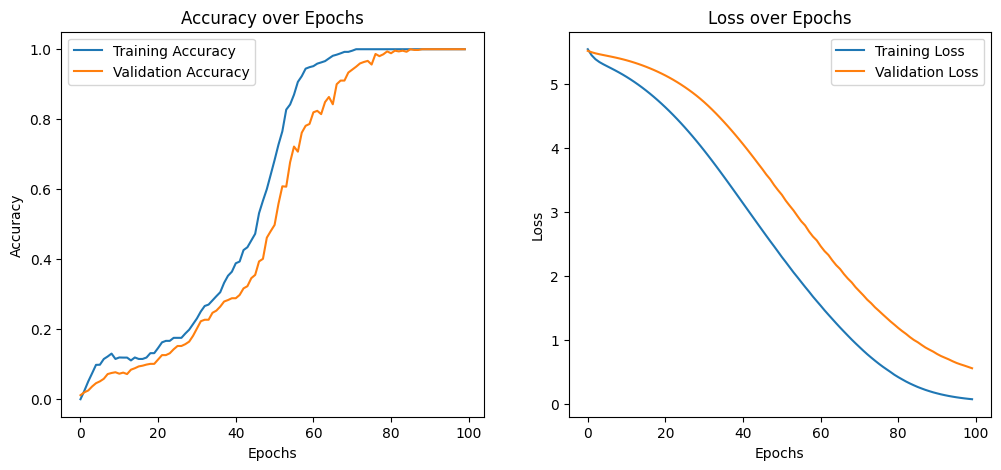

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 984ms/step - accuracy: 1.0000 - loss: 0.0715 - val_accuracy: 1.0000 - val_loss: 0.5559
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 1.0000 - loss: 0.5440
Test Loss: 0.5448, Test Accuracy: 1.0000


In [ ]:
# Autoencoder Class with Convolutional Layers
class AE:
    def __init__(self, train_data, val_data, test_data, input_dim=K, enc_dim=N, act_fun='relu'):
        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data
        self.input_dim = input_dim
        self.enc_dim = enc_dim
        self.act_fun = act_fun


    def AE_implement(self):
        autoencoder = Sequential([
            Input(shape=(1,),batch_size = batch_size),  # Add this input layer
            # Embedding Layer (Input: message indices)
            Embedding(input_dim=M, output_dim=256, input_length=1, name="Embedding"),
            Flatten(),  # Flatten output to feed into Conv1D layers

            # Encoder (Multiple Conv1D layers)
            Reshape((1, 256)),  # Reshape for Conv1D
            Conv1D(256, kernel_size=1, activation='elu', name="Conv1D_1"),
            Conv1D(128, kernel_size=1, activation='elu', name="Conv1D_2"),
            Conv1D(64, kernel_size=1, activation='elu', name="Conv1D_3"),
            Conv1D(2*N, kernel_size=1, activation='linear', name="Conv1D_4"),

            # # Power Normalization Layer (L2 normalization over 2N dimensions)
            # tf.keras.layers.Lambda(lambda x: tf.nn.l2_normalize(x, axis=-1)),

            Normalization(input_shape=(1, 8),name= "normal"),
            # Custom Noise Layer (Simulating the channel)
            SlidingWindowConcatLayer1(window_size=13,name="sliding_window"),
            StochasticChannelv3(name="StochasticChannel"),
            CustomNoise(name="NoiseLayer"),
            SD(name="SD"),

            Reshape((1, 58)),  # Reshape for Conv1D_dec1
            # Decoder (Conv1D layers to reconstruct the input)
            Conv1D(64, kernel_size=1, activation='elu', name="Conv1D_Dec1"),
            Conv1D(128, kernel_size=1, activation='elu', name="Conv1D_Dec2"),
            Conv1D(256, kernel_size=1, activation='elu', name="Conv1D_Dec3"),

            # Output Layer with Softmax to predict the message index
            Flatten(),
            Dense(output, activation='softmax', name="Output")
        ])

        # Compile the model
        autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005,beta_1=0.9, beta_2=0.999,epsilon=1e-07),
                            loss='sparse_categorical_crossentropy',
                            metrics=['accuracy'])
        return autoencoder


        # Training Class with Early Stopping and Plotting
    def train(self, epochs=40, batch_size=32):
        autoencoder = self.AE_implement()

        log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

        history = autoencoder.fit(self.train_data, self.train_data,
                                  epochs=epochs, batch_size=batch_size,
                                  validation_data=(self.val_data, self.val_data),
                                  callbacks=[PlottingCallback(), tensorboard_callback])
        return autoencoder, history


# Custom Callback for Real-time Plotting
class PlottingCallback(Callback):
    def __init__(self):
        super(PlottingCallback, self).__init__()
        self.history = {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}

    def on_epoch_end(self, epoch, logs=None):
        self.history['accuracy'].append(logs.get('accuracy'))
        self.history['val_accuracy'].append(logs.get('val_accuracy'))
        self.history['loss'].append(logs.get('loss'))
        self.history['val_loss'].append(logs.get('val_loss'))

        clear_output(wait=True)

        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(self.history['accuracy'], label='Training Accuracy')
        plt.plot(self.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Accuracy over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(self.history['loss'], label='Training Loss')
        plt.plot(self.history['val_loss'], label='Validation Loss')
        plt.title('Loss over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.show()



# Instantiate and Train
ae = AE(train_data=train_set, val_data=val_set, test_data=test_dataset, input_dim=K, enc_dim=N, act_fun='tanh')
autoencoder_model, history = ae.train(epochs=100, batch_size=batch_size)

# Evaluate the model
loss, accuracy = autoencoder_model.evaluate(test_dataset, test_dataset)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

In [ ]:
autoencoder_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Embedding (Embedding)                │ (6400, 1, 256)              │          65,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (6400, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (6400, 1, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv1D_1 (Conv1D)                    │ (6400, 1, 256)              │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv1D_2 (Conv1D)                    │ (6400, 1, 128)              │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv1D_3 (Conv1D)                    │ (6400, 1, 64)               │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv1D_4 (Conv1D)                    │ (6400, 1, 8)                │             520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normal (Normalization)               │ (6400, 1, 8)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sliding_window                       │ (6400, 1, 104)              │               0 │
│ (SlidingWindowConcatLayer1)          │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ StochasticChannel                    │ (6400, 476)                 │               0 │
│ (StochasticChannelv3)                │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ NoiseLayer (CustomNoise)             │ (6400, 476)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ SD (SD)                              │ (6400, 58)                  │         439,098 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (6400, 1, 58)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv1D_Dec1 (Conv1D)                 │ (6400, 1, 64)               │           3,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv1D_Dec2 (Conv1D)                 │ (6400, 1, 128)              │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv1D_Dec3 (Conv1D)                 │ (6400, 1, 256)              │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (6400, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (6400, 256)                 │          65,792 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,169,032 (8.27 MB)

 Trainable params: 723,010 (2.76 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,446,022 (5.52 MB)

In [ ]:
pip install tf_keras

In [ ]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"
import tensorflow

In [ ]:
import tf_keras as keras
from tf_keras import layers

In [ ]:
autoencoder_model.save("myModelTF.keras")

In [ ]:
autoencoder_model.save('autoencoder_model.h5')

### Encoder and Decoder


In [ ]:
encode_output = autoencoder_model.get_layer('sliding_window').output
input_tensor = autoencoder_model.get_layer(name='Embedding').input
Encoder = tf.keras.Model(inputs=input_tensor, outputs=encode_output)
Encoder.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (6400, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Embedding (Embedding)                │ (6400, 1, 256)              │          65,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (6400, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (6400, 1, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv1D_1 (Conv1D)                    │ (6400, 1, 256)              │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv1D_2 (Conv1D)                    │ (6400, 1, 128)              │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv1D_3 (Conv1D)                    │ (6400, 1, 64)               │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv1D_4 (Conv1D)                    │ (6400, 1, 8)                │             520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normal (Normalization)               │ (6400, 1, 8)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sliding_window                       │ (6400, 1, 104)              │               0 │
│ (SlidingWindowConcatLayer1)          │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 173,000 (675.78 KB)

 Trainable params: 173,000 (675.78 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
decoder_input = autoencoder_model.get_layer('SD').input
output_tensor = autoencoder_model.get_layer(name='Output').output
Decoder = tf.keras.Model(inputs=decoder_input, outputs=output_tensor)
Decoder.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ keras_tensor_11CLONE (InputLayer)    │ (6400, 476)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ SD (SD)                              │ (6400, 58)                  │         439,098 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (6400, 1, 58)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv1D_Dec1 (Conv1D)                 │ (6400, 1, 64)               │           3,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv1D_Dec2 (Conv1D)                 │ (6400, 1, 128)              │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv1D_Dec3 (Conv1D)                 │ (6400, 1, 256)              │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (6400, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (6400, 256)                 │          65,792 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 550,010 (2.10 MB)

 Trainable params: 550,010 (2.10 MB)

 Non-trainable params: 0 (0.00 B)

## Encoded msgs of Datasets

In [ ]:
from scipy.io import savemat

Encoder_train_set = Encoder.predict(train_set)
Encoder_train_set = tf.squeeze(Encoder_train_set, axis=1)
Encoder_train_set = Encoder_train_set.numpy()

Encoder_Val_set = Encoder.predict(val_set)
Encoder_Val_set = tf.squeeze(Encoder_Val_set, axis=1)
Encoder_Val_set = Encoder_Val_set.numpy()

Encoder_Test_set = Encoder.predict(test_dataset)
Encoder_Test_set = tf.squeeze(Encoder_Test_set, axis=1)
Encoder_Test_set = Encoder_Test_set.numpy()

savemat('Encoder_Train_set.mat', {'Encoder_Train_set': Encoder_train_set})
savemat('Encoder_Val_set.mat', {'Encoder_Val_set': Encoder_Val_set})
savemat('Encoder_Test_set.mat', {'Encoder_Test_set': Encoder_Test_set})

print(Encoder_train_set.shape)
print(Encoder_Val_set.shape)
print(Encoder_Test_set.shape)
# savemat('Encoder_Train_set.mat', {'Encoder_Train_set': Encoder_Train_set})


170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
(5440, 104)
(960, 104)
(3072, 104)


## Alphabet

In [ ]:
alphabet = np.tile(np.arange(M),13)
alphabet = alphabet.reshape(-1,1)
print(alphabet.shape)
pad = np.zeros((6,1),dtype=int)
alphabet = np.vstack([pad,alphabet,pad])
alphabet = Encoder.predict(alphabet)
alphabet = tf.squeeze(alphabet, axis=1)

alphabet = alphabet.numpy()

savemat('alphabet.mat', {'alphabet': alphabet})

# print(alphabet+1)

(3328, 1)
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
